<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 7 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 23 October 2019</div>

- Some of you came to see me during office hours for help on this homework, and it is clear you were having fun but the models remained a tad complicated with strange runtime errors. So i've decided to help you a bit more and go deeper into the modeling and give you another week to submit this homework. 

What happens if you can't get your hands on a dataset, and you need to scrape data from a web site? This notebook teaches you how to do it. And then models one of the columns, builds a Bayesian model based on an analysis of the data-generating dynamics, and runs some tests to see if the analysis is probably correct. It's a virtual coach!

# Bayesian Baseball analytics

I found this beautiful baseball results Web site, [fangraphs](https://www.fangraphs.com/). Let's scape some data (probably better to use the Tom Brady sport analytics package, but I wanted to show you how to scrape data off of Web pages).

For the game of baseball, I will concentrate on **attack** and **defense** as *independent* parameters. **Batting** for attack, and I will neglect **Fielding** in defense and concentrate solely on **pitching** (starters, not closers). This is not good, but i'm professor, so I can do that (you can't).

</br >
<center>
<img src="ipynb.images/calvin-grin.jpg" width=200 />
</center>

I also ***won't*** consider *all* players on the team, there's ***too many of them***. Moreover, many players remain on the bench and some (like pitchers) are on a rotation and play only every 5 games or so.

# Getting the data

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

Scraping Web pages with `Beautiful soup`:
```(python)
pip install BeautifulSoup
pip install requests
```

In [34]:
def get_soup_team_pitching(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0"
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

In [35]:
def get_soup_team_batting(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate="
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

In [36]:
def get_soup_players_pitching(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

In [37]:
def get_soup_players_batting(season):
    url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2019&month=0&season1=" + str(season) + "&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
    s=requests.get(url).content
    #print(s)
    return BeautifulSoup(s, "lxml")

Finding the tables. First, some exploratory work:

In [38]:
get_soup_players_batting(2019).find_all('table')[1]

<table class="menu-team-table">
<tr>
<td>
<div class="menu-sub-header">AL East</div>
<a href="//www.fangraphs.com/teams/blue-jays">Blue Jays</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=14">DC</a><br/>
<a href="//www.fangraphs.com/teams/orioles">Orioles</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=2">DC</a><br/>
<a href="//www.fangraphs.com/teams/rays">Rays</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=12">DC</a><br/>
<a href="//www.fangraphs.com/teams/red-sox">Red Sox</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=3">DC</a><br/>
<a href="//www.fangraphs.com/teams/yankees">Yankees</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=9">DC</a><br/>
</td>
<td>
<div class="menu-sub-header">AL Central</div>
<a href="//www.fangraphs.com/teams/indians">Indians</a>  |  <a href="//www.fangraphs.com/depthcharts.aspx?position=ALL&amp;teamid=5">

Ok, let's code!

In [39]:
def get_table_pitching(soup, team = True):
   
    tables = soup.find_all('table')
    table = tables[12]
    data = []
    # couldn't find these in the table, hardcoding for now
    if team:
        headings = ["Team", "W","L","SV","G","GS","IP","SO","K/9","BB/9","HR/9","BABIP","LOB%","GB%","HR/FB","ERA","FIP","xFIP","WAR"]
    else:
        headings = ["Name","Team","W","L","SV","G","GS","IP","SO","K/9","BB/9","HR/9","BABIP","LOB%","GB%","HR/FB","ERA","FIP","xFIP","WAR"]

    data.append(headings)
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols[1:]])
    data = pd.DataFrame(data)
    data = data.rename(columns=data.iloc[0])
    data = data.reindex(data.index.drop(0))
    return data

In [40]:
def get_table_batting(soup, team = True):

    tables = soup.find_all('table')
    table = tables[12]
    data = []
    # couldn't find these in the table, hardcoding for now
    if team:
        headings = ["Team", "G","PA","HR","R","RBI","SB","BB%","K%","ISO","BABIP","AVG","OBP","SLG","wOBA","wRC+","BsR","Off", "Def", "WAR"]
    else:
        headings = ["Name","Team", "G","PA","HR","R","RBI","SB","BB%","K%","ISO","BABIP","AVG","OBP","SLG","wOBA","wRC+","BsR","Off", "Def", "WAR"]

    data.append(headings)
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols[1:]])
    data = pd.DataFrame(data)
    data = data.rename(columns=data.iloc[0])
    data = data.reindex(data.index.drop(0))
    return data

Getting the pandas dataframes:

In [450]:
teams_pitching = get_table_pitching(get_soup_team_pitching(2019))
teams_pitching.head()

,Team,W,L,SV,G,GS,IP,SO,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,ERA,FIP,xFIP,WAR
1,Rays,96,66,46,765,162,1474.1,9.90,2.77,1.10,.290,73.8 %,44.1 %,13.4 %,3.67,3.65,3.89,25.3,None
2,Dodgers,106,56,44,707,162,1445.2,9.46,2.44,1.15,.271,74.7 %,44.9 %,14.1 %,3.39,3.73,3.87,24.1,None
3,Twins,101,61,50,686,162,1463.1,9.00,2.78,1.22,.309,71.8 %,41.8 %,13.4 %,4.18,4.03,4.27,23.9,None
4,Astros,107,55,47,654,162,1462.1,10.28,2.76,1.42,.270,76.8 %,43.6 %,16.7 %,3.66,3.98,3.80,23.7,None
5,Nationals,93,69,40,692,162,1439.1,9.45,3.23,1.26,.296,73.0 %,42.6 %,13.9 %,4.28,4.14,4.32,22.3,None


In [451]:
teams_batting = get_table_batting(get_soup_team_batting(2019))
teams_batting.head()

,Team,G,PA,HR,R,RBI,SB,BB%,K%,ISO,BABIP,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR
1,Astros,2309,6394,288,920,891,67,10.1 %,18.2 %,.221,.296,.274,.352,.495,.355,125,-9.5,196.6,-2.5,40.8
2,Dodgers,2413,6281,279,886,861,57,9.7 %,21.6 %,.215,.291,.257,.338,.472,.338,111,11.9,102.9,51.7,34.8
3,Yankees,2312,6245,306,943,904,55,9.1 %,23.0 %,.222,.306,.267,.339,.490,.346,117,-0.8,130.8,-14.5,32.7
4,Twins,2320,6392,307,939,906,28,8.2 %,20.9 %,.224,.300,.270,.338,.494,.347,116,-8.4,120.2,-26.7,31.0
5,Athletics,2363,6269,257,845,800,49,9.2 %,21.3 %,.199,.282,.249,.327,.448,.327,107,-1.7,53.4,18.3,28.5


Go [here](https://www.baseball-reference.com/bullpen/Baseball_statistics) for an explanation of each of the columns.

In [452]:
players_pitching = get_table_pitching(get_soup_players_pitching(2019), team = False)
players_pitching.head()

,Name,Team,W,L,SV,G,GS,IP,SO,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,ERA,FIP,xFIP,WAR
1,Gerrit Cole,Astros,20,5,0,33,33,212.1,13.82,2.03,1.23,.275,83.3 %,40.3 %,16.9 %,2.50,2.64,2.48,7.4,None
2,Jacob deGrom,Mets,11,8,0,32,32,204.0,11.25,1.94,0.84,.282,81.8 %,44.4 %,11.2 %,2.43,2.67,3.11,7.0,None
3,Lance Lynn,Rangers,16,11,0,33,33,208.1,10.63,2.55,0.91,.322,74.4 %,40.3 %,9.9 %,3.67,3.13,3.85,6.8,None
4,Max Scherzer,Nationals,11,7,0,27,27,172.1,12.69,1.72,0.94,.321,78.7 %,40.8 %,11.6 %,2.92,2.45,2.88,6.5,None
5,Justin Verlander,Astros,21,6,0,34,34,223.0,12.11,1.70,1.45,.218,88.4 %,35.9 %,16.0 %,2.58,3.27,3.18,6.4,None


In [453]:
players_batting = get_table_batting(get_soup_players_batting(2019), team = False)
players_batting.head()

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,BABIP,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR
1,Mike Trout,Angels,134,600,45,110,104,11,18.3 %,20.0 %,...,.298,.291,.438,.645,.436,180,7.1,68.2,-0.3,8.6
2,Alex Bregman,Astros,156,690,41,122,112,5,17.2 %,12.0 %,...,.281,.296,.423,.592,.418,168,-2.1,58.2,4.8,8.5
3,Christian Yelich,Brewers,130,580,44,100,97,30,13.8 %,20.3 %,...,.355,.329,.429,.671,.442,174,8.5,65.2,-3.9,7.8
4,Cody Bellinger,Dodgers,156,660,47,121,115,15,14.4 %,16.4 %,...,.302,.305,.406,.629,.415,162,1.4,55.3,3.4,7.8
5,Marcus Semien,Athletics,162,747,33,123,92,10,11.6 %,13.7 %,...,.294,.285,.369,.522,.373,137,1.7,37.5,14.1,7.6


In [454]:
num_teams = len(teams_batting)
num_teams

30

In [455]:
num_batters = len(players_batting)
num_batters

30

In [456]:
num_pitchers = len(players_pitching)
num_pitchers

30

What's wrong with ***these*** results?

<div style="display:none;">
The number of pitchers and the number of batters ***equals*** the number of teams! How is ***that*** possible?!
</div>

ok... Back to the drawing board!

### Python regexes

In [ ]:
import re
txt = "The rain in Spain"
x = re.search("^The.*Spain$", txt)
x

In [457]:
txt = get_soup_players_batting(2019).find_all('table')[12]
txt

<table class="rgMasterTable" id="LeaderBoard1_dg1_ctl00" style="table-layout:auto;empty-cells:show;" width="100%">
<colgroup>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
<col/>
</colgroup>
<thead>
<tr class="rgPager">
<td class="rgPagerCell" colspan="22"><div class="NextPrevAndNumeric rgSEO">
<div class="rgWrap rgArrPart1">
<a class="t-button rgActionButton rgPageFirst" title="First Page"><span class="t-font-icon rgIcon"></span></a><a class="t-button rgActionButton rgPagePrev" title="Previous Page"><span class="t-font-icon rgIcon"></span></a>
</div><div class="rgWrap rgNumPart">
<a class="rgCurrentPage" href="javascript:__doPostBack('LeaderBoard1$dg1$ctl00$ctl02$ctl00$ctl07','')" onclick="return false;">1</a><a href="/leaders.aspx?pos=all&amp;stats=bat&amp;lg=all&amp;qual=y&amp;type=8&amp;season=2019&amp;month=0&amp;season1=2019&amp;ind=0&amp;team=0&amp;rost=0&amp;age=0&amp;filter=&am

In [458]:
x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
x

<_sre.SRE_Match object; span=(3799, 3847), match='<strong>135</strong> items in <strong>5</strong>'>

In [ ]:
import re

# <strong>135</strong> items in <strong>5</strong> pages
txt = get_soup_players_batting(2019).find_all('table')[12]
#txt
x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
match = x.group()
start = match.find('>')
match = match[start:]
end = match.find('<')
print(match[1: end])

y = re.search("items in \<strong\>.*\</strong\>", x.group())
match = y.group()
start = match.find('>')
end = match.rfind('<')
start, end
print(int(match[start + 1: end]))

Putting this all together:

In [ ]:
season = 2019
url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
perpage, pages = get_num_tables_players_pitching(2019)
perpage, pages

In [ ]:
season = 2019
url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
perpage, pages = get_num_tables_players_pitching(2019)
print(str(perpage) + ", " + str(pages))
df_all = []

pd.set_option('display.max_rows', None)

for i in range(0, 4):
    url2 = url + "&page=" + str(i+5) + "_" + str(30)
    print(url2)
    s=requests.get(url2).content
    soup = BeautifulSoup(s, "lxml")
    df_all.append(get_table_pitching(soup, team = False))
    time.sleep(60)
newpd = pd.concat(df_all, ignore_index= True)
newpd

In [459]:
import re

def get_num_tables_players_pitching(season):
    txt = get_soup_players_pitching(season).find_all('table')[12]
    x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
    match = x.group()
    start = match.find('>')
    match = match[start:]
    end = match.find('<')
    perpage = int(match[1: end])

    y = re.search("items in \<strong\>.*\</strong\>", x.group())
    match = y.group()
    start = match.find('>')
    end = match.rfind('<')
    pages = int(match[start + 1: end])
    
    return perpage, pages

In [460]:
import re

def get_num_tables_players_batting(season):
    txt = get_soup_players_batting(season).find_all('table')[12]
    x = re.search("\<strong\>.*\</strong\> items in \<strong\>.*\</strong\>", str(txt))
    match = x.group()
    start = match.find('>')
    match = match[start:]
    end = match.find('<')
    perpage = int(match[1: end])
    
    y = re.search("items in \<strong\>.*\</strong\>", x.group())
    match = y.group()
    start = match.find('>')
    end = match.rfind('<')
    pages = int(match[start + 1: end])
    
    return perpage, pages

In [461]:
get_num_tables_players_pitching(2019)

(61, 3)

In [462]:
get_num_tables_players_batting(2019)

(135, 5)

The commented out part of the code is the right way of doing it, but `fangraphs` is **throttling** the Web site, so instead
I found a hack to get most of the data, looking at what happens to the browser URL when i select the next page in the table, and then emulating that with larger rows per page (what a hack).

In [41]:
def get_table_batting_2(season, team = True):

    if team:
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate="
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_batting(soup, team = True)
    
    else:
        #url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=2019&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
        #perpage, pages = get_num_tables_players_pitching(2019)
        #df_all = []
        #for i in range(0, pages):
        #    url2 = ulr + "&page=" + str(i) + "_" + str(perpage)
        #    s=requests.get(url2).content
        #    soup = BeautifulSoup(s, "lxml")
        #    df_all.append(get_tables_batting(soup, team = False))
        #    time.sleep(60)
        #return pd.concat(df_all)
        
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=1_900"
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_batting(soup, team = False)

In [42]:
import time

def get_table_pitching_2(season, team = True):

    if team:
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate="
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_pitching(soup, team = True)
    
    else:
        #url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate="
        #perpage, pages = get_num_tables_players_pitching(2019)
        #pages = 4
        #df_all = []
        #for i in range(0, pages):
        #    url2 = url + "&page=" + str(i) + "_" + str(perpage)
        #    s=requests.get(url2).content
        #    soup = BeautifulSoup(s, "lxml")
        #    df_all.append(get_tables_pitching(soup, team = False))
        #    time.sleep(60)
        #return pd.concat(df_all)
        
        url = "https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=y&type=8&season=" + str(season) + "&month=0&season1=2019&ind=0&team=0&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=1_200"
        s=requests.get(url).content
        soup = BeautifulSoup(s, "lxml")
        return get_table_pitching(soup, team = False)

## Better? Let's see

Getting the `pandas` dataframes:

In [43]:
teams_pitching = get_table_pitching_2(2019, team = True)
teams_pitching.head()

,Team,W,L,SV,G,GS,IP,SO,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,ERA,FIP,xFIP,WAR
1,Rays,96,66,46,765,162,1474.1,9.90,2.77,1.10,.290,73.8 %,44.1 %,13.4 %,3.67,3.65,3.89,25.3,None
2,Dodgers,106,56,44,707,162,1445.2,9.46,2.44,1.15,.271,74.7 %,44.9 %,14.1 %,3.39,3.73,3.87,24.1,None
3,Twins,101,61,50,686,162,1463.1,9.00,2.78,1.22,.309,71.8 %,41.8 %,13.4 %,4.18,4.03,4.27,23.9,None
4,Astros,107,55,47,654,162,1462.1,10.28,2.76,1.42,.270,76.8 %,43.6 %,16.7 %,3.66,3.98,3.80,23.7,None
5,Nationals,93,69,40,692,162,1439.1,9.45,3.23,1.26,.296,73.0 %,42.6 %,13.9 %,4.28,4.14,4.32,22.3,None


In [44]:
teams_batting = get_table_batting_2(2019, team = True)
teams_batting.head()

,Team,G,PA,HR,R,RBI,SB,BB%,K%,ISO,BABIP,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR
1,Astros,2309,6394,288,920,891,67,10.1 %,18.2 %,.221,.296,.274,.352,.495,.355,125,-9.5,196.6,-2.5,40.8
2,Dodgers,2413,6281,279,886,861,57,9.7 %,21.6 %,.215,.291,.257,.338,.472,.338,111,11.9,102.9,51.7,34.8
3,Yankees,2312,6245,306,943,904,55,9.1 %,23.0 %,.222,.306,.267,.339,.490,.346,117,-0.8,130.8,-14.5,32.7
4,Twins,2320,6392,307,939,906,28,8.2 %,20.9 %,.224,.300,.270,.338,.494,.347,116,-8.4,120.2,-26.7,31.0
5,Athletics,2363,6269,257,845,800,49,9.2 %,21.3 %,.199,.282,.249,.327,.448,.327,107,-1.7,53.4,18.3,28.5


This is so we can see ***all*** pandas rows (or set it to a numer of your choosing):

In [ ]:
pd.set_option('display.max_rows', None)

In [45]:
players_pitching = get_table_pitching_2(2019, team = False)
players_pitching.head()

,Name,Team,W,L,SV,G,GS,IP,SO,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,ERA,FIP,xFIP,WAR
1,Gerrit Cole,Astros,20,5,0,33,33,212.1,13.82,2.03,1.23,.275,83.3 %,40.3 %,16.9 %,2.50,2.64,2.48,7.4,None
2,Jacob deGrom,Mets,11,8,0,32,32,204.0,11.25,1.94,0.84,.282,81.8 %,44.4 %,11.2 %,2.43,2.67,3.11,7.0,None
3,Lance Lynn,Rangers,16,11,0,33,33,208.1,10.63,2.55,0.91,.322,74.4 %,40.3 %,9.9 %,3.67,3.13,3.85,6.8,None
4,Max Scherzer,Nationals,11,7,0,27,27,172.1,12.69,1.72,0.94,.321,78.7 %,40.8 %,11.6 %,2.92,2.45,2.88,6.5,None
5,Justin Verlander,Astros,21,6,0,34,34,223.0,12.11,1.70,1.45,.218,88.4 %,35.9 %,16.0 %,2.58,3.27,3.18,6.4,None


In [46]:
players_pitching

,Name,Team,W,L,SV,G,GS,IP,SO,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,ERA,FIP,xFIP,WAR
1,Gerrit Cole,Astros,20,5,0,33,33,212.1,13.82,2.03,1.23,.275,83.3 %,40.3 %,16.9 %,2.50,2.64,2.48,7.4,None
2,Jacob deGrom,Mets,11,8,0,32,32,204.0,11.25,1.94,0.84,.282,81.8 %,44.4 %,11.2 %,2.43,2.67,3.11,7.0,None
3,Lance Lynn,Rangers,16,11,0,33,33,208.1,10.63,2.55,0.91,.322,74.4 %,40.3 %,9.9 %,3.67,3.13,3.85,6.8,None
4,Max Scherzer,Nationals,11,7,0,27,27,172.1,12.69,1.72,0.94,.321,78.7 %,40.8 %,11.6 %,2.92,2.45,2.88,6.5,None
5,Justin Verlander,Astros,21,6,0,34,34,223.0,12.11,1.70,1.45,.218,88.4 %,35.9 %,16.0 %,2.58,3.27,3.18,6.4,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Jakob Junis,Royals,9,14,0,31,31,175.1,8.42,2.98,1.59,.318,70.3 %,42.4 %,16.7 %,5.24,4.82,4.63,1.5,None
58,Zach Eflin,Phillies,10,13,0,32,28,163.1,7.11,2.64,1.54,.291,73.9 %,44.6 %,16.0 %,4.13,4.85,4.76,1.5,None
59,Jeff Samardzija,Giants,11,12,0,32,32,181.1,6.95,2.43,1.39,.240,76.9 %,36.4 %,12.6 %,3.52,4.59,5.02,1.5,None
60,Dakota Hudson,Cardinals,16,7,1,33,32,174.2,7.01,4.43,1.13,.274,78.1 %,56.9 %,19.8 %,3.35,4.93,4.55,1.0,None


In [47]:
players_batting = get_table_batting_2(2019, team = False)
players_batting.head()

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,BABIP,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR
1,Mike Trout,Angels,134,600,45,110,104,11,18.3 %,20.0 %,...,.298,.291,.438,.645,.436,180,7.1,68.2,-0.3,8.6
2,Alex Bregman,Astros,156,690,41,122,112,5,17.2 %,12.0 %,...,.281,.296,.423,.592,.418,168,-2.1,58.2,4.8,8.5
3,Christian Yelich,Brewers,130,580,44,100,97,30,13.8 %,20.3 %,...,.355,.329,.429,.671,.442,174,8.5,65.2,-3.9,7.8
4,Cody Bellinger,Dodgers,156,660,47,121,115,15,14.4 %,16.4 %,...,.302,.305,.406,.629,.415,162,1.4,55.3,3.4,7.8
5,Marcus Semien,Athletics,162,747,33,123,92,10,11.6 %,13.7 %,...,.294,.285,.369,.522,.373,137,1.7,37.5,14.1,7.6


In [48]:
players_batting

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,BABIP,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR
1,Mike Trout,Angels,134,600,45,110,104,11,18.3 %,20.0 %,...,.298,.291,.438,.645,.436,180,7.1,68.2,-0.3,8.6
2,Alex Bregman,Astros,156,690,41,122,112,5,17.2 %,12.0 %,...,.281,.296,.423,.592,.418,168,-2.1,58.2,4.8,8.5
3,Christian Yelich,Brewers,130,580,44,100,97,30,13.8 %,20.3 %,...,.355,.329,.429,.671,.442,174,8.5,65.2,-3.9,7.8
4,Cody Bellinger,Dodgers,156,660,47,121,115,15,14.4 %,16.4 %,...,.302,.305,.406,.629,.415,162,1.4,55.3,3.4,7.8
5,Marcus Semien,Athletics,162,747,33,123,92,10,11.6 %,13.7 %,...,.294,.285,.369,.522,.373,137,1.7,37.5,14.1,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,Miguel Cabrera,Tigers,136,549,12,41,59,0,8.7 %,19.7 %,...,.336,.282,.346,.398,.318,96,-6.3,-8.9,-13.9,-0.3
132,Eric Hosmer,Padres,160,667,22,72,99,0,6.0 %,24.4 %,...,.323,.265,.310,.425,.309,91,-5.2,-13.1,-12.4,-0.4
133,Albert Pujols,Angels,131,545,23,55,93,3,7.9 %,12.5 %,...,.238,.244,.305,.430,.308,93,-4.4,-9.3,-13.9,-0.4
134,Orlando Arcia,Brewers,152,546,15,51,59,8,7.9 %,20.0 %,...,.253,.223,.283,.350,.269,61,0.9,-27.3,5.4,-0.4


In [49]:
num_teams = len(teams_batting)
num_teams

30

In [50]:
num_batters = len(players_batting)
num_batters

135

In [51]:
num_pitchers = len(players_pitching)
num_pitchers

61

Ok, I think we still don't have all the batter and pitchers, but we have definitely have more of them!

If you look at the fangraphs Web site, you will see we ***still did not get all the data***? Can you fix this?

On to the **model**!

# Offense parameters

From [Sabermetrics](https://en.wikipedia.org/wiki/Sabermetrics), I get the important player attack parameters:

- [On-Base plus Slugging](https://en.wikipedia.org/wiki/On-base_plus_slugging): Ability of a player both to get on base and to hit for power (OPS = OBP + SLG)
- [Wins Above Replacement](https://en.wikipedia.org/wiki/Wins_Above_Replacement): Sums up a player's total contributions to his team

In [52]:
# adding a new calculated field
players_batting['OPS'] = players_batting['OBP'].astype(float) / 2. + players_batting['SLG'].astype(float) / 2.

This will be my reduced dataset:

In [53]:
offense = players_batting[['Name', 'Team', 'OPS', 'WAR']]
offense.head()

,Name,Team,OPS,WAR
1,Mike Trout,Angels,0.5415,8.6
2,Alex Bregman,Astros,0.5075,8.5
3,Christian Yelich,Brewers,0.5500,7.8
4,Cody Bellinger,Dodgers,0.5175,7.8
5,Marcus Semien,Athletics,0.4455,7.6


# Defense parameters

After reading [this](https://www.beyondtheboxscore.com/2014/6/2/5758898/sabermetrics-stats-pitching-stats-learn-sabermetrics) article, I will pick BABIP and FIP as representative of pitching prowess, and focus solely on pitching as defense. Obviously, fielding and throwing and closing are three other big dimensions of the game, which i neglect here.

In [54]:
defense = players_pitching[['Name', 'Team', 'BABIP', 'FIP']]
defense.head()

,Name,Team,BABIP,FIP
1,Gerrit Cole,Astros,83.3 %,2.48
2,Jacob deGrom,Mets,81.8 %,3.11
3,Lance Lynn,Rangers,74.4 %,3.85
4,Max Scherzer,Nationals,78.7 %,2.88
5,Justin Verlander,Astros,88.4 %,3.18


# Game summary statistics

The right way of proceeding is to analyze ***every game of the season*** (like our football notbook did). But it's ok to start with a simpler model as ***first iteration***. 

So, instead of looking at ***every game***, i'm going to look at ***season averages***.  Note that in the football notebook, we modelled each **game played**, whereas here, we are modelling a **season**. Always start with ***a very simple model***.

For team power, I will concentrate on the differential between game wins and losses in the season in the same way as goal differential per game in  my football notebook. 

I will also neglect home field advantage.

In [55]:
teams_pitching['WLdiff'] = teams_pitching['W'].astype(int) - teams_pitching['L'].astype(int)
teams = teams_pitching[['Team', 'WLdiff']]
teams.sort_values(by=['WLdiff'], ascending=False).head(20)

,Team,WLdiff
4,Astros,52
2,Dodgers,50
10,Yankees,44
3,Twins,40
8,Athletics,32
18,Braves,32
1,Rays,30
5,Nationals,24
6,Indians,24
13,Cardinals,20


In [56]:
len(teams)

30

In [57]:
teams_batting['RBIs'] = teams_batting['RBI'].astype(int)
teams2 = teams_batting[['Team', 'RBIs']]
teams2.sort_values(by=['RBIs'], ascending=False).head(20)

,Team,RBIs
4,Twins,906
3,Yankees,904
1,Astros,891
2,Dodgers,861
6,Red Sox,857
7,Braves,824
8,Nationals,824
24,Rockies,803
5,Athletics,800
9,Cubs,783


In [58]:
len(teams2)

30

In [59]:
teams['Team'].values

array(['Rays', 'Dodgers', 'Twins', 'Astros', 'Nationals', 'Indians',
       'Mets', 'Athletics', 'Reds', 'Yankees', 'Cubs', 'Red Sox',
       'Cardinals', 'Padres', 'Rangers', 'Diamondbacks', 'Brewers',
       'Braves', 'White Sox', 'Tigers', 'Blue Jays', 'Pirates',
       'Phillies', 'Royals', 'Giants', 'Rockies', 'Marlins', 'Mariners',
       'Angels', 'Orioles'], dtype=object)

In [60]:
teams2['Team'].values

array(['Astros', 'Dodgers', 'Yankees', 'Twins', 'Athletics', 'Red Sox',
       'Braves', 'Nationals', 'Cubs', 'Brewers', 'Mets', 'Diamondbacks',
       'Rays', 'Cardinals', 'Phillies', 'Angels', 'Indians', 'Mariners',
       'Padres', 'Blue Jays', 'Reds', 'White Sox', 'Pirates', 'Rockies',
       'Giants', 'Royals', 'Rangers', 'Orioles', 'Marlins', 'Tigers'],
      dtype=object)

In [61]:
teams_wl = teams.set_index('Team')
teams_wl

,WLdiff
Team,
Rays,30
Dodgers,50
Twins,40
Astros,52
Nationals,24
Indians,24
Mets,10
Athletics,32
Reds,-12


In [62]:
observed_wins_losses = teams_wl['WLdiff'].values
observed_wins_losses

array([ 30,  50,  40,  52,  24,  24,  10,  32, -12,  44,   6,   6,  20,
       -22,  -6,   8,  16,  32, -17, -67, -28, -24,   0, -44,  -8, -20,
       -48, -26, -18, -54])

In [63]:
mlb_teams_by_wins_losses = teams_wl.index
mlb_teams_by_wins_losses

Index(['Rays', 'Dodgers', 'Twins', 'Astros', 'Nationals', 'Indians', 'Mets',
       'Athletics', 'Reds', 'Yankees', 'Cubs', 'Red Sox', 'Cardinals',
       'Padres', 'Rangers', 'Diamondbacks', 'Brewers', 'Braves', 'White Sox',
       'Tigers', 'Blue Jays', 'Pirates', 'Phillies', 'Royals', 'Giants',
       'Rockies', 'Marlins', 'Mariners', 'Angels', 'Orioles'],
      dtype='object', name='Team')

In [64]:
teams_rbi = teams2.set_index('Team')
teams_rbi

,RBIs
Team,
Astros,891
Dodgers,861
Yankees,904
Twins,906
Athletics,800
Red Sox,857
Braves,824
Nationals,824
Cubs,783


In [65]:
teams_rbi_sorted = teams_rbi.sort_values(by=['RBIs'], ascending=False)
teams_rbi_sorted.head(20)

,RBIs
Team,
Twins,906
Yankees,904
Astros,891
Dodgers,861
Red Sox,857
Braves,824
Nationals,824
Rockies,803
Athletics,800


In [66]:
observed_rbis = teams_rbi_sorted['RBIs'].values
observed_rbis

array([906, 904, 891, 861, 857, 824, 824, 803, 800, 783, 778, 767, 765,
       744, 742, 734, 731, 730, 730, 722, 714, 698, 697, 679, 676, 655,
       655, 652, 593, 556])

In [67]:
mlb_teams_by_rbis = teams_rbi_sorted.index
mlb_teams_by_rbis

Index(['Twins', 'Yankees', 'Astros', 'Dodgers', 'Red Sox', 'Braves',
       'Nationals', 'Rockies', 'Athletics', 'Cubs', 'Diamondbacks', 'Mets',
       'Rangers', 'Brewers', 'Phillies', 'Angels', 'Indians', 'Mariners',
       'Rays', 'Pirates', 'Cardinals', 'Orioles', 'Blue Jays', 'Reds',
       'White Sox', 'Giants', 'Royals', 'Padres', 'Marlins', 'Tigers'],
      dtype='object', name='Team')

In [68]:
mlb_teams_by_rbis_index = pd.DataFrame(mlb_teams_by_rbis)
mlb_teams_by_rbis_index

,Team
0,Twins
1,Yankees
2,Astros
3,Dodgers
4,Red Sox
5,Braves
6,Nationals
7,Rockies
8,Athletics
9,Cubs


In [69]:
mlb_teams_by_rbis_index_values = mlb_teams_by_rbis_index.index
mlb_teams_by_rbis_index_values

RangeIndex(start=0, stop=30, step=1)

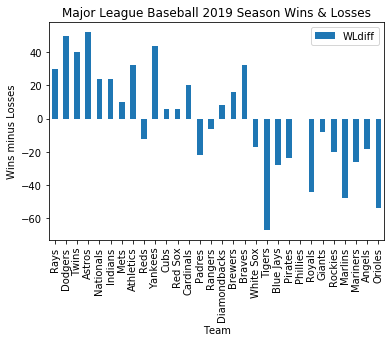

In [70]:
(teams_wl
      .plot(kind='bar', title='Major League Baseball 2019 Season Wins & Losses')
      .set_ylabel('Wins minus Losses'));

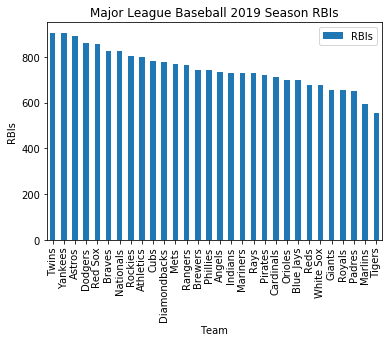

In [71]:
(teams_rbi_sorted
      .plot(kind='bar', title='Major League Baseball 2019 Season RBIs')
      .set_ylabel('RBIs'));

Do you see how Twins, Yankees, Astros, and Dodgers scored many RBIs and also figure on top in the Wins - Losses board? These teams are all in the posteseason right now. But who's ***right after them***, with *almost the same amount of RBIs*, and yet is *not* playing in this posteason?

</br >
<center>
<img src="ipynb.images/redsox.jpg" width=200 />
</center>

So although the Red Sox was a power hitting team, their **defense** and/or their **coaching**/game-strategy was ***sub-par***. In the end, it's **Wins** minus **Losses** that takes you to the post-season, not RBIs.

## Building a Bayesian Model: The Priors

We know that a count outcome is most often modelled as a Poisson distribution. We will model **effective** team strength as $y$ as a Poisson distribution: $(y\;|\;θ_j) \propto Poisson(θ_j)$ where the $\theta_j$ parameters represent team attacking (OPS and WAR) and defensive parameters (BABIP and FIP).

Instead of considering the OPS and WAR of each batter, and the BABIP and FIP of each hitter, we'll simplify and consider only the top 5 batters in the [batting order](https://en.wikipedia.org/wiki/Batting_order_(baseball), and the top 5 starting pitchers in the [pitching rotation](https://en.wikipedia.org/wiki/Starting_pitcher).

We aren't even considering the **bullpen pitchers** (closers), who make ***such a huge difference in the last 3 innings***!

So how many prior parameters in total? **5 \* 2 + 5 \* 2 = 20 per team**. For 30 teams, this is a total of ***600 model parameters***!

We will model our ***per-team*** $\theta$ as an exponential of **twenty** independent variables: two attack variables **att** for each of the top 5 batters, and two defense variables **def** for each of the top 5 pitchers, times a constant factor k. We won't base this on a ***per game***/played (e.g. $att_g$) model as we did with football (although we could have, but then maybe we have so many more model parameters that we probably need to run on AWS), but on a ***per team***/season model (e.g. $att_t$).

Let's assume the index $b$ for batters (attack), and $p$ for pitchers (defense). 

$$θ = k * \Pi_be^{\text{att1}_b} * \Pi_be^{\text{att2}_b} * \Pi_pe^{\text{def1}_p} * \Pi_pe^{\text{def2}_p}$$

Our priors are thus modeled with a **log-linear** random effect model, a common procedure in sports analytics. 

$$\log(θ) = \text{intercept} + \sum_b\text{att1}_b + \sum_b\text{att2}_b + \sum_p\text{def1}_p + \sum_p\text{def2}_p$$

For each team $t = 1, \cdots, T$, team-specific attack and defense effects are modelled from normal distributions:
$att1_b \propto \text{Normal}(μ_{att1},τ_{att1})$, $att2_b \propto \text{Normal}(μ_{att2},τ_{att2})$, and $def1_p \propto \text{Normal}(μ_{def1}, τ_{def1})$, $def2_p \propto \text{Normal}(μ_{def2}, τ_{def2})$.

To further simplify, we'll set $τ_{att2} = τ_{att1}$ and $τ_{def2} = τ_{def1}$.

We now build a model in `PyMC3`, specifying global parameters, team-specific parameters, and likelihood function.

# On 2nd thought..

This model *may* work, but it's the ***wrong start***. Too *complex* for a start. We need to take baby steps!

</br >
<center>
<img src="ipynb.images/baby-steps.png" width=400 />
</center>

So what we'll do is to ***sum*** the attack & defense factors we picked from the top-5 pitchers and batters, to get team averages. Since `fangraphs` is throttling our requests, we'll just get as many players from each team as we can.

Batters:
- WAR
- OBS = OBP + SLG

Pitchers:
- BABIF
- FIP

We'll use pandas' `groupby()` API to compute team averages, aggregating players-per-team values.

## Batters

In [72]:
players_batting_war = players_batting[['Name', 'Team', 'WAR']]
players_batting_war.head()

,Name,Team,WAR
1,Mike Trout,Angels,8.6
2,Alex Bregman,Astros,8.5
3,Christian Yelich,Brewers,7.8
4,Cody Bellinger,Dodgers,7.8
5,Marcus Semien,Athletics,7.6


In [73]:
players_batting_war.groupby(['Team'])['WAR'].agg('sum')

Team
- - -              2.81.91.51.41.21.0
Angels                  8.63.42.5-0.4
Astros             8.56.54.23.53.21.0
Athletics            7.66.13.91.3-1.0
Blue Jays                      0.50.4
Braves                5.64.94.64.01.5
Brewers           7.85.22.81.91.5-0.4
Cardinals             4.13.72.92.61.5
Cubs                  4.84.44.02.61.9
Diamondbacks         7.13.72.42.2-0.1
Dodgers               7.84.83.43.33.0
Giants                      2.00.50.4
Indians                  4.44.43.31.1
Mariners                    1.60.00.0
Marlins                     3.11.91.3
Mets                  4.84.63.72.71.4
Nationals             7.04.83.52.52.3
Orioles                  4.03.61.90.6
Padres                        3.1-0.4
Phillies              5.74.62.32.21.7
Pirates            3.23.02.52.42.20.1
Rangers                  1.91.71.40.3
Rays                     4.03.32.81.8
Red Sox         6.86.65.93.53.22.01.4
Reds                        4.51.60.7
Rockies                  5.95.82.00.6
Royals 

oooops.. Why are we getting averages as string concatenations? Can you guess?

<div style="display:none;">
Because WARs are listed as string types! So let's convert them to floats!
</div>

In [74]:
players_batting['WARs'] = players_batting['WAR'].astype(float) 
players_batting_war = players_batting[['Name', 'Team', 'WARs']]
players_batting_war.head()

,Name,Team,WARs
1,Mike Trout,Angels,8.6
2,Alex Bregman,Astros,8.5
3,Christian Yelich,Brewers,7.8
4,Cody Bellinger,Dodgers,7.8
5,Marcus Semien,Athletics,7.6


In [75]:
wars = players_batting_war.groupby(['Team'])['WARs'].agg('sum')
wars

Team
- - -            9.8
Angels          14.1
Astros          26.9
Athletics       17.9
Blue Jays        0.9
Braves          20.6
Brewers         18.8
Cardinals       14.8
Cubs            17.7
Diamondbacks    15.3
Dodgers         22.3
Giants           2.9
Indians         13.2
Mariners         1.6
Marlins          6.3
Mets            17.2
Nationals       20.1
Orioles         10.1
Padres           2.7
Phillies        16.5
Pirates         13.4
Rangers          5.3
Rays            11.9
Red Sox         29.4
Reds             6.8
Rockies         14.3
Royals          10.8
Tigers          -0.3
Twins           13.9
White Sox       15.3
Yankees         14.3
Name: WARs, dtype: float64

Let's get rid of the empty team row (first row above):

In [76]:
wars = wars[1:]
wars

Team
Angels          14.1
Astros          26.9
Athletics       17.9
Blue Jays        0.9
Braves          20.6
Brewers         18.8
Cardinals       14.8
Cubs            17.7
Diamondbacks    15.3
Dodgers         22.3
Giants           2.9
Indians         13.2
Mariners         1.6
Marlins          6.3
Mets            17.2
Nationals       20.1
Orioles         10.1
Padres           2.7
Phillies        16.5
Pirates         13.4
Rangers          5.3
Rays            11.9
Red Sox         29.4
Reds             6.8
Rockies         14.3
Royals          10.8
Tigers          -0.3
Twins           13.9
White Sox       15.3
Yankees         14.3
Name: WARs, dtype: float64

And let's rescale since the WAR numbers are so much higher than the other factors.

In [77]:
from sklearn import preprocessing
nwars = preprocessing.scale(wars) + 2  #+2 so we don't get into negative numbers
nwars

array([2.12766291, 3.87846848, 2.64743331, 0.32214466, 3.01674386,
       2.77053683, 2.22341009, 2.62007697, 2.29180093, 3.24927273,
       0.59570803, 2.00455939, 0.41789184, 1.06076576, 2.55168613,
       2.94835302, 1.58053616, 0.56835169, 2.45593895, 2.03191573,
       0.92398407, 1.8267432 , 4.22042269, 1.1291566 , 2.15501924,
       1.67628334, 0.15800664, 2.10030657, 2.29180093, 2.15501924])

In [78]:
list(nwars)

[2.1276629064071564,
 3.878468479991017,
 2.647433311064865,
 0.3221446586488006,
 3.016743861742711,
 2.7705368279574802,
 2.2234100862125237,
 2.6200769739776173,
 2.291800928930644,
 3.2492727269843176,
 0.5957080295212787,
 2.0045593895145415,
 0.41789183845416766,
 1.0607657600044915,
 2.551686131259497,
 2.9483530190245912,
 1.5805361646622003,
 0.568351692434031,
 2.4559389514541303,
 2.031915726601789,
 0.9239840745682524,
 1.8267431984474305,
 4.2204226935816145,
 1.129156602722611,
 2.1550192434944044,
 1.6762833444675675,
 0.1580066361253134,
 2.1003065693199083,
 2.291800928930644,
 2.1550192434944044]

On second thought, this is more straightforward:

In [79]:
wars = players_batting_war.groupby(['Team'])['WARs'].agg('mean')
wars

Team
- - -           1.633333
Angels          3.525000
Astros          4.483333
Athletics       3.580000
Blue Jays       0.450000
Braves          4.120000
Brewers         3.133333
Cardinals       2.960000
Cubs            3.540000
Diamondbacks    3.060000
Dodgers         4.460000
Giants          0.966667
Indians         3.300000
Mariners        0.533333
Marlins         2.100000
Mets            3.440000
Nationals       4.020000
Orioles         2.525000
Padres          1.350000
Phillies        3.300000
Pirates         2.233333
Rangers         1.325000
Rays            2.975000
Red Sox         4.200000
Reds            2.266667
Rockies         3.575000
Royals          2.700000
Tigers         -0.300000
Twins           3.475000
White Sox       2.550000
Yankees         3.575000
Name: WARs, dtype: float64

In [80]:
wars = wars[1:]
wars

Team
Angels          3.525000
Astros          4.483333
Athletics       3.580000
Blue Jays       0.450000
Braves          4.120000
Brewers         3.133333
Cardinals       2.960000
Cubs            3.540000
Diamondbacks    3.060000
Dodgers         4.460000
Giants          0.966667
Indians         3.300000
Mariners        0.533333
Marlins         2.100000
Mets            3.440000
Nationals       4.020000
Orioles         2.525000
Padres          1.350000
Phillies        3.300000
Pirates         2.233333
Rangers         1.325000
Rays            2.975000
Red Sox         4.200000
Reds            2.266667
Rockies         3.575000
Royals          2.700000
Tigers         -0.300000
Twins           3.475000
White Sox       2.550000
Yankees         3.575000
Name: WARs, dtype: float64

Now for OPS:

In [81]:
players_batting['OPS'] = players_batting['OBP'].astype(float) / 2. + players_batting['SLG'].astype(float) / 2.
players_batting_ops = players_batting[['Name', 'Team', 'OPS']]
players_batting_ops.head()

,Name,Team,OPS
1,Mike Trout,Angels,0.5415
2,Alex Bregman,Astros,0.5075
3,Christian Yelich,Brewers,0.5500
4,Cody Bellinger,Dodgers,0.5175
5,Marcus Semien,Athletics,0.4455


In [82]:
opss = players_batting_ops.groupby(['Team'])['OPS'].agg('mean')
opss

Team
- - -           0.392083
Angels          0.418000
Astros          0.448250
Athletics       0.402600
Blue Jays       0.377250
Braves          0.432000
Brewers         0.414250
Cardinals       0.392700
Cubs            0.431700
Diamondbacks    0.411600
Dodgers         0.450000
Giants          0.359667
Indians         0.410625
Mariners        0.364167
Marlins         0.376000
Mets            0.423500
Nationals       0.434700
Orioles         0.401625
Padres          0.382750
Phillies        0.400500
Pirates         0.413667
Rangers         0.389000
Rays            0.409000
Red Sox         0.429929
Reds            0.403833
Rockies         0.449750
Royals          0.418125
Tigers          0.372000
Twins           0.440875
White Sox       0.397333
Yankees         0.429375
Name: OPS, dtype: float64

In [83]:
opss = opss[1:]
opss

Team
Angels          0.418000
Astros          0.448250
Athletics       0.402600
Blue Jays       0.377250
Braves          0.432000
Brewers         0.414250
Cardinals       0.392700
Cubs            0.431700
Diamondbacks    0.411600
Dodgers         0.450000
Giants          0.359667
Indians         0.410625
Mariners        0.364167
Marlins         0.376000
Mets            0.423500
Nationals       0.434700
Orioles         0.401625
Padres          0.382750
Phillies        0.400500
Pirates         0.413667
Rangers         0.389000
Rays            0.409000
Red Sox         0.429929
Reds            0.403833
Rockies         0.449750
Royals          0.418125
Tigers          0.372000
Twins           0.440875
White Sox       0.397333
Yankees         0.429375
Name: OPS, dtype: float64

## Pitchers

In [84]:
players_pitching_babip = players_pitching[['Name', 'Team', 'BABIP']]
players_pitching_babip.head()

,Name,Team,BABIP
1,Gerrit Cole,Astros,83.3 %
2,Jacob deGrom,Mets,81.8 %
3,Lance Lynn,Rangers,74.4 %
4,Max Scherzer,Nationals,78.7 %
5,Justin Verlander,Astros,88.4 %


We need to get rid of the trailing ` %`:

In [85]:
def rchop(thestring, ending):
    if thestring.endswith(ending):
        return thestring[:-len(ending)]
    return thestring

#somestring = rchop(somestring, '  %')

In [86]:
players_pitching['BABIPs'] = [float(rchop(b, ' %'))/100. for b in players_pitching['BABIP']]
players_pitching['BABIPs']

1     0.833
2     0.818
3     0.744
4     0.787
5     0.884
      ...  
57    0.703
58    0.739
59    0.769
60    0.781
61    0.726
Name: BABIPs, Length: 61, dtype: float64

In [87]:
players_pitching_babip = players_pitching[['Name', 'Team', 'BABIPs']]
players_pitching_babip.head()

,Name,Team,BABIPs
1,Gerrit Cole,Astros,0.833
2,Jacob deGrom,Mets,0.818
3,Lance Lynn,Rangers,0.744
4,Max Scherzer,Nationals,0.787
5,Justin Verlander,Astros,0.884


In [88]:
babips = players_pitching_babip.groupby(['Team'])['BABIPs'].agg('mean')
babips

Team
- - -           0.740167
Astros          0.820000
Athletics       0.766500
Braves          0.769333
Cardinals       0.779250
Cubs            0.717000
Diamondbacks    0.741000
Dodgers         0.790667
Giants          0.743500
Indians         0.774000
Mariners        0.692000
Marlins         0.738000
Mets            0.740333
Nationals       0.768500
Padres          0.730000
Phillies        0.753500
Pirates         0.632000
Rangers         0.773500
Rays            0.753000
Red Sox         0.717000
Reds            0.780333
Rockies         0.681000
Royals          0.712500
Tigers          0.744000
Twins           0.705500
White Sox       0.732333
Yankees         0.704000
Name: BABIPs, dtype: float64

In [89]:
babips = babips[1:]
babips

Team
Astros          0.820000
Athletics       0.766500
Braves          0.769333
Cardinals       0.779250
Cubs            0.717000
Diamondbacks    0.741000
Dodgers         0.790667
Giants          0.743500
Indians         0.774000
Mariners        0.692000
Marlins         0.738000
Mets            0.740333
Nationals       0.768500
Padres          0.730000
Phillies        0.753500
Pirates         0.632000
Rangers         0.773500
Rays            0.753000
Red Sox         0.717000
Reds            0.780333
Rockies         0.681000
Royals          0.712500
Tigers          0.744000
Twins           0.705500
White Sox       0.732333
Yankees         0.704000
Name: BABIPs, dtype: float64

In [90]:
len(babips)

26

In [91]:
players_pitching['FIPs'] = players_pitching['FIP'].astype(float)
players_pitching_fip = players_pitching[['Name', 'Team', 'FIPs']]
players_pitching_fip.head()

,Name,Team,FIPs
1,Gerrit Cole,Astros,2.48
2,Jacob deGrom,Mets,3.11
3,Lance Lynn,Rangers,3.85
4,Max Scherzer,Nationals,2.88
5,Justin Verlander,Astros,3.18


In [92]:
fips = players_pitching_fip.groupby(['Team'])['FIPs'].agg('mean')
fips

Team
- - -           4.315000
Astros          3.393333
Athletics       4.990000
Braves          4.143333
Cardinals       4.190000
Cubs            4.050000
Diamondbacks    4.170000
Dodgers         3.396667
Giants          4.665000
Indians         3.230000
Mariners        5.110000
Marlins         5.170000
Mets            3.666667
Nationals       3.685000
Padres          4.360000
Phillies        4.290000
Pirates         4.310000
Rangers         4.225000
Rays            3.280000
Red Sox         4.620000
Reds            3.810000
Rockies         3.540000
Royals          4.785000
Tigers          3.880000
Twins           4.505000
White Sox       4.613333
Yankees         4.290000
Name: FIPs, dtype: float64

In [93]:
fips = fips[1:]
fips

Team
Astros          3.393333
Athletics       4.990000
Braves          4.143333
Cardinals       4.190000
Cubs            4.050000
Diamondbacks    4.170000
Dodgers         3.396667
Giants          4.665000
Indians         3.230000
Mariners        5.110000
Marlins         5.170000
Mets            3.666667
Nationals       3.685000
Padres          4.360000
Phillies        4.290000
Pirates         4.310000
Rangers         4.225000
Rays            3.280000
Red Sox         4.620000
Reds            3.810000
Rockies         3.540000
Royals          4.785000
Tigers          3.880000
Twins           4.505000
White Sox       4.613333
Yankees         4.290000
Name: FIPs, dtype: float64

In [94]:
len(fips)

26

In [95]:
mlb_teams = fips.index
mlb_teams

Index(['Astros', 'Athletics', 'Braves', 'Cardinals', 'Cubs', 'Diamondbacks',
       'Dodgers', 'Giants', 'Indians', 'Mariners', 'Marlins', 'Mets',
       'Nationals', 'Padres', 'Phillies', 'Pirates', 'Rangers', 'Rays',
       'Red Sox', 'Reds', 'Rockies', 'Royals', 'Tigers', 'Twins', 'White Sox',
       'Yankees'],
      dtype='object', name='Team')

In [96]:
len(mlb_teams)

26

In [97]:
new_num_teams = len(mlb_teams)
new_num_teams

26

In [98]:
teams_wl

,WLdiff
Team,
Rays,30
Dodgers,50
Twins,40
Astros,52
Nationals,24
Indians,24
Mets,10
Athletics,32
Reds,-12


In [99]:
len(teams_wl)

30

We started off with 30 teams with our batters, and now we're down to 26 for pitchers. What happened? Probably because we did not get all the pitchers from `fangraphs`. Let's hack around this and reduce the number of teams in our batters list to 26.

In [100]:
teams_wl2 = teams_wl.reindex(mlb_teams)
teams_wl2

,WLdiff
Team,
Astros,52
Athletics,32
Braves,32
Cardinals,20
Cubs,6
Diamondbacks,8
Dodgers,50
Giants,-8
Indians,24


In [101]:
teams_wl2.values.T

array([[ 52,  32,  32,  20,   6,   8,  50,  -8,  24, -26, -48,  10,  24,
        -22,   0, -24,  -6,  30,   6, -12, -20, -44, -67,  40, -17,  44]])

In [102]:
len(teams_wl2)

26

We create new `wars2` and `opss2` factors to reflect our teams reduction:

In [103]:
wars2 = wars.reindex(mlb_teams)
wars2

Team
Astros          4.483333
Athletics       3.580000
Braves          4.120000
Cardinals       2.960000
Cubs            3.540000
Diamondbacks    3.060000
Dodgers         4.460000
Giants          0.966667
Indians         3.300000
Mariners        0.533333
Marlins         2.100000
Mets            3.440000
Nationals       4.020000
Padres          1.350000
Phillies        3.300000
Pirates         2.233333
Rangers         1.325000
Rays            2.975000
Red Sox         4.200000
Reds            2.266667
Rockies         3.575000
Royals          2.700000
Tigers         -0.300000
Twins           3.475000
White Sox       2.550000
Yankees         3.575000
Name: WARs, dtype: float64

In [104]:
len(opss)

30

In [105]:
opss

Team
Angels          0.418000
Astros          0.448250
Athletics       0.402600
Blue Jays       0.377250
Braves          0.432000
Brewers         0.414250
Cardinals       0.392700
Cubs            0.431700
Diamondbacks    0.411600
Dodgers         0.450000
Giants          0.359667
Indians         0.410625
Mariners        0.364167
Marlins         0.376000
Mets            0.423500
Nationals       0.434700
Orioles         0.401625
Padres          0.382750
Phillies        0.400500
Pirates         0.413667
Rangers         0.389000
Rays            0.409000
Red Sox         0.429929
Reds            0.403833
Rockies         0.449750
Royals          0.418125
Tigers          0.372000
Twins           0.440875
White Sox       0.397333
Yankees         0.429375
Name: OPS, dtype: float64

In [106]:
opss2 = opss.reindex(mlb_teams)
opss2

Team
Astros          0.448250
Athletics       0.402600
Braves          0.432000
Cardinals       0.392700
Cubs            0.431700
Diamondbacks    0.411600
Dodgers         0.450000
Giants          0.359667
Indians         0.410625
Mariners        0.364167
Marlins         0.376000
Mets            0.423500
Nationals       0.434700
Padres          0.382750
Phillies        0.400500
Pirates         0.413667
Rangers         0.389000
Rays            0.409000
Red Sox         0.429929
Reds            0.403833
Rockies         0.449750
Royals          0.418125
Tigers          0.372000
Twins           0.440875
White Sox       0.397333
Yankees         0.429375
Name: OPS, dtype: float64

In [107]:
len(opss2)

26

So we lost the Angels, Blue Jays, Brewers, and the Orioles.

## Building a Bayesian Model: The Likelihood 

Ok, we have what we think (if our model is correct) **team priors** for **attack** and **defense** in baseball. Now let's specity our likelihood function in `pymc3`. 

We know that whenever we have a small number of data point (about 30 or less), the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) gives better results than the normal distribution. 

The **half-t distribution** (also denoted **folded-t**) is derived from the t-distribution by taking the absolute values of variates. Since we already know the sign of `att` and `def` parameters, we don't want any negative signs. I will use the half student-t distribution to model standard deviations, but I will start my model building with normal distributions for the priors. If I get bad results, I may have to come back here and replace with student-t's instead.

Since we have a linear model for log$\theta$, we have a *slope-intercept* formula: $y = mx + b$ where $m$ is the slope or the consistent change between $x$ and $y$, and $b$ is the y-intercept (intercepts the y-axis at $y = b$). It is the expected mean value of $y$ when $x = 0$.

# Model 1: A loose model

A log-linear model with loose normal pdf priors, where the log of the Poisson paramater is a linear combination of the priors (plus a bias).

To see if our offense and defense factors are appropriate for the model, let's run a trace and see if the posteriors redistribute the means or if they stay a the same positions.

We'll specify a full model, and then immediately simplify it.

Here's the ***full*** model in `pymc3` (we ***won't*** run this):

In [108]:
num_teams

30

In [ ]:
batters = range(0, 5)
pitchers = range(0, 5)

In [52]:
import pymc3 as pm, theano.tensor as tt

with pm.Model() as model:
    # GLOBAL model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's att and def parameters stem from the same folded-t distribution.
    # Note use of student-t because we only have 30 teams, low number.
    # Note mean and standard deviation for our priors, picked from a hat like a rabbit!
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') #no idea

    # TEAM-specific model parameters. There are five (att1s_star, att2s_star) tuples per team (one for each top-5 batter),
    # and five (def1s_star, def2s_star) tuples per team (one for each top-5 pitcher). Thus, 20 priors per team! We have 30
    # teams, so that's 600 parameters for our model!!
    # Note use of normal distribution because we assume we have a lot of data per team
    att1s_star = pm.Normal("att1s_star", mu=wars2, sd=sd_att, shape=num_teams * len(batters))
    att2s_star = pm.Normal("att2s_star", mu=opss2, sd=sd_att, shape=num_teams * len(batters))
    def1s_star = pm.Normal("def1s_star", mu=babips, sd=sd_def, shape=num_teams * len(pitchers))
    def2s_star = pm.Normal("def2s_star", mu=fips, sd=sd_def, shape=num_teams * len(pitchers))

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    att1s = pm.Deterministic('att1s', att1s_star - tt.mean(att1s_star))
    att2s = pm.Deterministic('att2s', att2s_star - tt.mean(att2s_star))
    def1s = pm.Deterministic('def1s', def1s_star - tt.mean(def1s_star))
    def2s = pm.Deterministic('def2s', def2s_star - tt.mean(def2s_star))
    
    # Assume exponential search on theta and away_theta. We're relying on theano. No idea what to do when theano goes away..
    theta = tt.exp(intercept + 
                   att1s[mlb_teams_by_rbis_index][batters] + 
                   att1s[mlb_teams_by_rbis_index][batters] + 
                   def1s[mlb_teams_by_rbis_index][pitchers] + 
                   def2s[mlb_teams_by_rbis_index][pitchers])  

    # likelihood of observed data, Poisson distribution for count data
    wins = pm.Poisson('wins', mu=theta, observed=observed_wins_losses)

SyntaxError: invalid syntax (<ipython-input-52-36932041c484>, line 20)

In [ ]:
num_teams

In [ ]:
mlb_teams_by_rbis_index

In [ ]:
observed_wins_losses

Now, here's our ***simplified*** model:

In [109]:
len(wars2), len(opss2), len(babips), len(fips), new_num_teams

(26, 26, 26, 26, 26)

In [110]:
mlb_teams_by_rbis_index_2 = range(0, 26)
mlb_teams_by_rbis_index_2

range(0, 26)

In [51]:
import pymc3 as pm, theano.tensor as tt

with pm.Model() as model:
    # GLOBAL model priors: standard deviation and intercept.
    # We are saying that the standard deviation and intercept priors of each
    # team's att and def parameters stem from the same folded-t distribution.
    # Note use of student-t because we only have 30 teams, low number.
    # Note mean and standard deviation for our priors, picked from a hat like a rabbit!
    sd_att = pm.HalfStudentT('sd_att', nu=3, sd=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sd=2.5)
    intercept = pm.Flat('intercept') #no idea

    # TEAM-specific model parameters. There is one (att1s_star, att2s_star) tuple per team,
    # and one (def1s_star, def2s_star) tuple per team. Thus, 4 priors per team! We have 30
    # teams, so that's 120 parameters for our model!!
    # Note use of normal distribution because we assume we have a lot of data per team
    att1s_star = pm.Normal("att1s_star", mu=wars2, sd=sd_att, shape=new_num_teams)
    att2s_star = pm.Normal("att2s_star", mu=opss2, sd=sd_att, shape=new_num_teams)
    def1s_star = pm.Normal("def1s_star", mu=babips, sd=sd_def, shape=new_num_teams)
    def2s_star = pm.Normal("def2s_star", mu=fips, sd=sd_def, shape=new_num_teams)

    # To allow samples of expressions to be saved, we need to wrap them in pymc3 Deterministic objects
    # We save these parameters for later exploration.
    att1s = pm.Deterministic('att1s', att1s_star - tt.mean(att1s_star))
    att2s = pm.Deterministic('att2s', att2s_star - tt.mean(att2s_star))
    def1s = pm.Deterministic('def1s', def1s_star - tt.mean(def1s_star))
    def2s = pm.Deterministic('def2s', def2s_star - tt.mean(def2s_star))
    
    # Assume exponential search on theta and away_theta. We're relying on theano. No idea what to do when theano goes away..
    theta = tt.exp(intercept + 
                   att1s[mlb_teams_by_rbis_index_2] + 
                   att1s[mlb_teams_by_rbis_index_2] + 
                   def1s[mlb_teams_by_rbis_index_2] + 
                   def2s[mlb_teams_by_rbis_index_2])  

    # likelihood of observed data, Poisson distribution for count data
    #wins = pm.Poisson('wins', mu=theta, observed=teams_wl2.values)
    #wins = pm.Normal('wins', mu=theta, sd=sd_def, observed=teams_wl2.values)
    wins = pm.Normal('wins', mu=theta, sd=sd_def, observed=teams_wl3)

So let's think this through. We have `att1s_star`, `att2s_star`, `def1s_star`, `def1s_star` priors that are **very loosely specified** (just initial mean of our offense and defense point estimates) offense and defense ***normal pdfs***. If these priors are good models, then our posteriors should reflect this. That means our distributions will sharpen (smaller standard deviations), but the means should not redistribute as we converge in our simulation. If they do, that could mean that our model parameter choice may be overly ***simplistic***. 

</br >
<center>
<img src="ipynb.images/allright.gif" width=300 />
</center>

Allright allright allright! We have our model.

A *trace* is a MCMC sampling of your **posterior** probability distribution: the shape of your priors after matching them to our observations of the 2019 season. This yields the parameters for our model (`att` and `def` per team, for a log-linear model consisting of the top-5 batters and the top-5 pitchers) that are ***most likely to fit our observations***. 

We won't specify an algorithm. PyMC3 will most likely choose NUTS. Our parameter space is 120-dimensional! How long do you think this trace will take? Will it fry my kernel?

</br >
<center>
<img src="ipynb.images/dastardly.png" width=300 />
</center>

Metropolis:

In [49]:
with model:
    trace = pm.sample(10000, tune=1000, step=pm.Metropolis(), njobs = 1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [def2s_star]
>Metropolis: [def1s_star]
>Metropolis: [att2s_star]
>Metropolis: [att1s_star]
>Metropolis: [intercept]
>Metropolis: [sd_def]
>Metropolis: [sd_att]
100%|██████████| 11000/11000 [00:20<00:00, 537.17it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


NUTS:

In [ ]:
with model:
    trace = pm.sample(1000, tune=1000, cores=2)

Trace drawings:

d:\Anaconda3.5.1\lib\site-packages\pymc3\plots\traceplot.py:148: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002209363E1D0>,
      dtype=object)

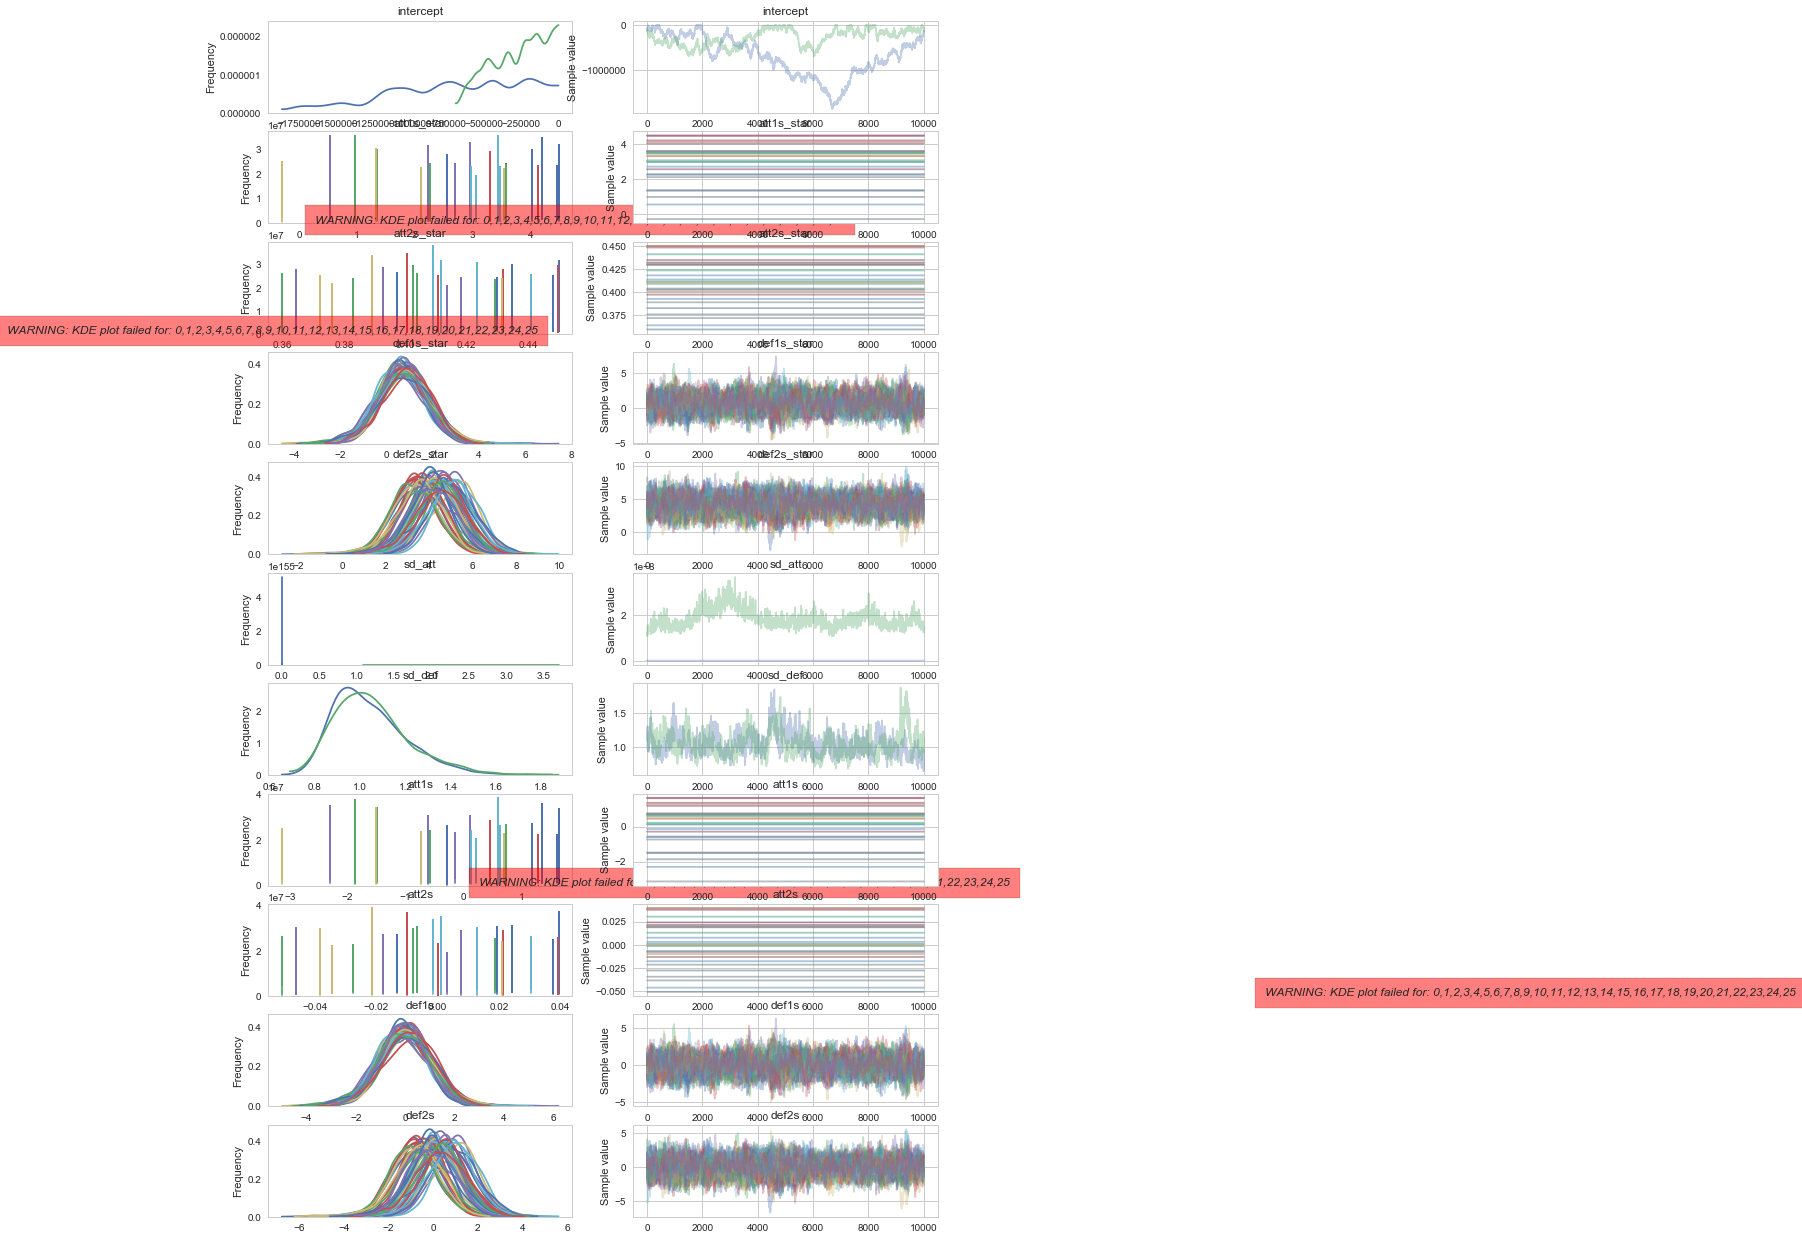

In [50]:
pm.traceplot(trace)

- Hmm... Looks like OPS and BABIPS factor traces did not converge. Could these parameters not be the right parameters to model team wins/losses with?

# Model 2: A tighter model

We model a ***team*** **power** stochastic variable $\lambda$ as a linear model of our **offense** ($\alpha$'s) and **defense** ($\beta$'s) sabermetrics factors:

$$\lambda_{i} = \alpha_{0i} + \alpha_{1i}(wars)_{i} + \alpha_{2i}(ops)_{i}  + \beta_{1i}(babips)_{i} + \beta_{2i}(fips)_{i}$$

Priors are now $\alpha_{0i}$ (intercept), $\alpha_{1i}$, $\alpha_{2i}$, $\beta_{1i}$, $\beta_{2i}$, for $i$ in 0, .., $N$ teams, expressed as pdfs.

And we model our likelihood as a **Poisson** distribution based on win/loss differentials:

$$\text{likelihood}_t = \text{Poisson}(\lambda_t,τ_t)$$

We then use PyMC3 Generalized Linear Model (GLM) syntax ([patsy](https://patsy.readthedocs.io/en/latest/formulas.html) style). It's this expression below, which says that we want win/loss differential to be a linear combination of the other variables: 

`win-loss ~ wars + ops + babips + fips`

We will use **Normal** priors to begin with, even though **Beta** priors are better for percentages, and **Gamma** priors for decimal counts. Note that we will model our $y$ (i.e. `win-loss`) as a **Poisson**, since it's an integer count model. Notive we use *very diffuse* gaussians, since the sigma is large.

Ok, don't run the cell below, yet. We still have to rebuild our `data` dataframe to account for all our priors. We do this in cells further below (run those *first*).

In [55]:
import pymc3 as pm
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('WL3 ~ WARs + OPS + BABIPs + FIPs',
                            data,
                            family=pm.glm.families.Normal())
    trace2 = pm.sample(1000, tune=1000, init='adapt_diag', njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, FIPs, BABIPs, OPS, WARs, Intercept]
100%|██████████| 2000/2000 [01:03<00:00, 32.19it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002209358DF98>,
      dtype=object)

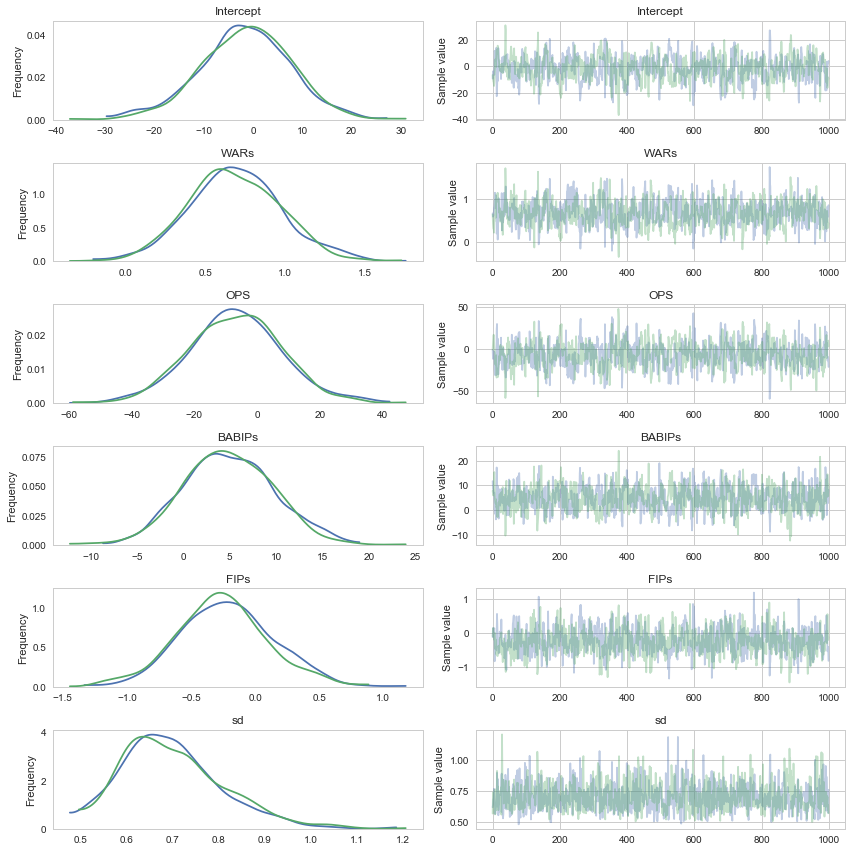

In [56]:
pm.traceplot(trace)

Let's test our model...

uh-oh... ***We didn't hold out any data for testing our model %U^%$^%%^&%!!!***

Let's generate fake data:

In [58]:
fake_data = pm.sample_ppc(trace, samples=1000, model=glm_model, size=100)
fake_data

100%|██████████| 1000/1000 [00:01<00:00, 543.39it/s]


defaultdict(list,
            {'y': array([[[ 1.70653915e+00,  2.34996439e+00,  9.54828639e-01, ...,
                      -1.61991802e+00, -4.17973236e-01,  2.81404970e-01],
                     [ 1.43255820e+00,  1.08632581e+00,  2.84447252e-01, ...,
                       1.69640272e+00, -8.14353275e-01,  8.02600790e-01],
                     [ 5.66068705e-01,  2.96176703e+00,  1.71345007e-01, ...,
                       1.09813528e-01, -1.00210037e+00, -6.02925163e-01],
                     ...,
                     [ 1.38326964e+00,  1.04633928e+00,  4.79358821e-01, ...,
                      -7.15264588e-01, -3.27707510e-01,  1.03714147e+00],
                     [ 2.16979918e+00,  2.18352832e+00,  2.06069181e+00, ...,
                      -2.89822560e-01,  3.25209909e-01,  7.92976144e-01],
                     [ 1.83813073e+00,  2.05766915e+00,  1.43512868e+00, ...,
                       8.07640465e-01, -4.89487625e-01, -6.66894984e-01]],
             
                    [[ 3

# Explicit Model

Let's try an **explicit** model, instead of using a patsy-style formula and using `pymc3`'s `glm.GLM.from_formula` API.

Note how our initial **Poisson** likelihood does not seem to converge: It gives us a `bad initial energy` condition. That usually means one of our stochastic variables has hit infinity in the sim. You can check which variable with the following API:
```(python)
mdl_ols.check_test_point()
```

So I use a **Normal** distribution instead and the `WL3` renormalized column. That sim seems to converge.

In [109]:
with pm.Model() as mdl_ols:
 ## define Normal priors to give Ridge regression
 c0 = pm.Normal('c0', mu=0, sd=100)
 b0 = pm.Normal('b0', mu=0, sd=100)
 b1 = pm.Normal('b1', mu=0, sd=100) 
 a0 = pm.Normal('a0', mu=0, sd=100)
 a1 = pm.Normal('a1', mu=0, sd=100)

 ## define Linear model
 theta = c0 + b0 * data['WARs'] + b1 * data['OPS'] + a0 * data['BABIPs'] + a1 * data['FIPs']

 ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
 sigma_y = pm.HalfCauchy('sigma_y', beta=10)
 #likelihood = pm.Normal('likelihood', mu=yest, sigma=sigma_y, observed=df_lin['y'])
 #likelihood = pm.Poisson('likelihood', mu=np.exp(theta), observed=data['WL'].values)
 #likelihood = pm.Poisson('likelihood', mu=theta, observed=data['WL'].values)
 likelihood = pm.Normal('likelihood', mu=theta, sd=sigma_y, observed=data['WL3'].values)

In [110]:
 with mdl_ols:
    traces_ols = pm.sample(2000, njobs = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_y, a1, a0, b1, b0, c0]
100%|██████████| 2500/2500 [01:33<00:00, 26.86it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000220A56D2588>,
      dtype=object)

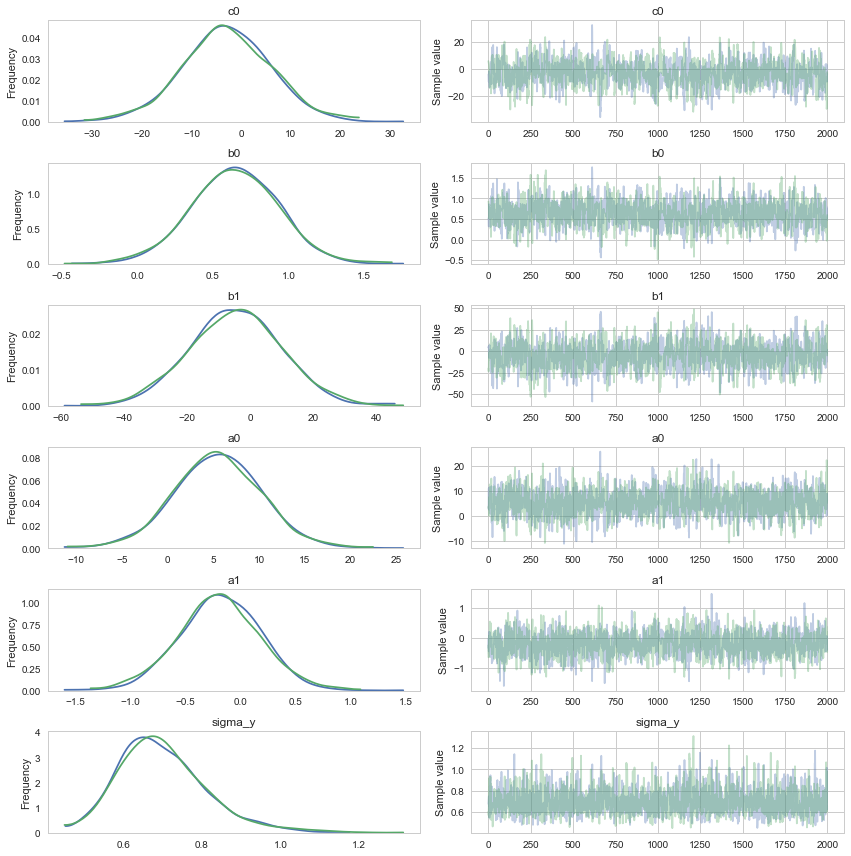

In [111]:
pm.traceplot(traces_ols)

## @@@@@@@@@@@ Random Forest to yield most likely factors

I know from the notebook that professor ran during our `pandas` lecture that a random forest was a good algorith to give us some hints as to which independent column is the most correlated with the dependent column. So let's use it to find the good factors to model baseball wins/losses! Will it verify that I picked the right offsense and defense factors? 

In [61]:
X = data[["WARs", "OPS", "BABIPs", "FIPs"]]
y = pd.Series(data["WL"].values)

In [62]:
X.head()

,WARs,OPS,BABIPs,FIPs
0,4.483333,0.44825,0.820000,3.393333
1,3.580000,0.40260,0.766500,4.990000
2,4.120000,0.43200,0.769333,4.143333
3,2.960000,0.39270,0.779250,4.190000
4,3.540000,0.43170,0.717000,4.050000


In [63]:
y

0     52
1     32
2     32
3     20
4      6
5      8
6     50
7     -8
8     24
9    -26
10   -48
11    10
12    24
13   -22
14     0
15   -24
16    -6
17    30
18     6
19   -12
20   -20
21   -44
22   -67
23    40
24   -17
25    44
dtype: int64

In [87]:
import sklearn
from sklearn.ensemble import RandomForestRegressor

Alternative 1:

In [88]:
import sklearn.grid_search as gs

In [89]:
%%time
param_grid = dict(
    max_features=np.arange(2, 5),
    max_depth=[2, 16],
    min_samples_split=[5, 10, 15, 20],
)
rfc = RandomForestRegressor(n_estimators=10)
g = gs.GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
g.fit(X.values, y.values)

Wall time: 4.44 s


In [90]:
scores = gs...grid_scores_
scores[:10]

AttributeError: module 'sklearn.grid_search' has no attribute 'grid_scores_'

In [86]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.Series(gs.best_estimator_.feature_importances_,
          index=X.columns).sort_values().plot(kind='barh')

AttributeError: module 'sklearn.grid_search' has no attribute 'best_estimator_'

Simpler alternative:

In [91]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X.values, y.values, test_size = 0.25,
                                                                           random_state = 42)

In [92]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 10, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [93]:
import numpy as np

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 8.46


Uh-oh..

In [94]:
# Saving feature names for later use
feature_list = list(X.columns)
feature_list

['WARs', 'OPS', 'BABIPs', 'FIPs']

In [95]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: WARs                 Importance: 0.62
Variable: BABIPs               Importance: 0.17
Variable: OPS                  Importance: 0.11
Variable: FIPs                 Importance: 0.1


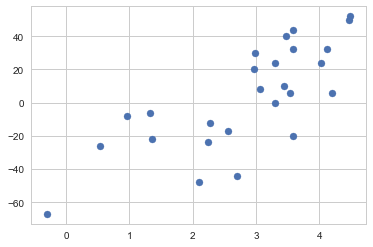

In [96]:
plt.scatter(wars2, teams_wl2.values)
plt.show()

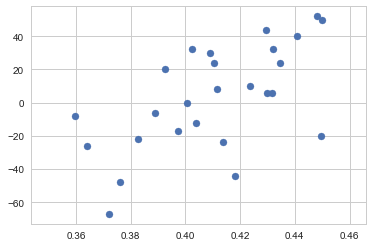

In [97]:
plt.scatter(opss2, teams_wl2.values)
plt.show()

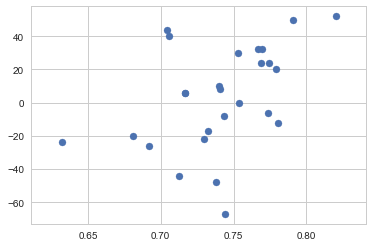

In [98]:
plt.scatter(babips, teams_wl2.values)
plt.show()

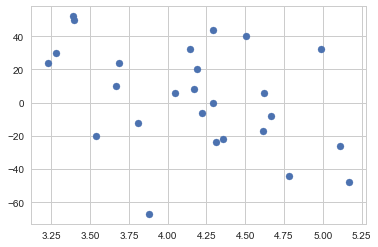

In [99]:
plt.scatter(fips, teams_wl2.values)
plt.show()

## @@@@@@@@@@@ end random forest pair plots

## @@@@@@@@@@@@@ Comparing models

### Watanabe-Akaike Information Criterion (WAIC) 
The Information Criterion [WAIC](https://en.wikipedia.org/wiki/Watanabe%E2%80%93Akaike_information_criterion) can be used to calculate the goodness-of-fit of a model using numerical techniques. 

See (Watanabe 2013) for details.

- waic: widely available information criterion
- waic_se: standard error of waic
- p_waic: effective number parameters

```(python)
dfwaic = pm.compare(model_trace, ic='WAIC')
```

You should prefer model(s) with lower WAIC.

### Leave-one-out Cross-Validation (LOO)
Leave-One-Out [Cross-Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics) or K-fold Cross-Validation is another universal approach for model selection. 

To implement K-fold cross-validation, you need to paritition data repeatedly and run the model on every partition. It can be very time consumming (computation time increase roughly as a factor of K). 

You should prefer the model(s) with lower LOO. LOO is nearly identical to WAIC, in fact WAIC is asymptotically equal to LOO. 

For the latest state of the art model selection method, there is general agreement in the community that Pareto-smoothed important sampling, or [PSIS-LOO](https://mouse-imaging-centre.github.io/blog/post/2018-01-31_loo-intro/), is the best method.

- Also, keep in mind that **quadratic** or **cubic** models of columns might be better, as we witnessed in our logistic modeling notebook. The only way to find out is to plot pair plots with respect to the dependent variables, eyeball possible qudratic fits, then run many different models overnight, and see which one yoields better WAIC or LOO.

Here is an example of what you could do, leveraging the simplicity of **patsy** notation.

In [113]:
def create_poly_model(k=1):
    #Create a polynomial modelspec string for patsy
    return ('y ~ 1 + x ' + ' '.join(['+ np.power(x,{})'.format(j) for j in range(2, k+1)])).strip()

def run_models(df, upper_order):
    models, traces, waic, loo = OrderedDict(), OrderedDict(), OrderedDict(), OrderedDict()
    for k in range(1, upper_order + 1):
        nm = 'k{}'.format(k)
        fml = create_poly_model(k)
        with pm.Model() as models[nm]:
            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Normal())
            traces[nm] = pm.sample(2000, tune=1000, init='advi+adapt_diag')
            waic = ...
            loo = ...
    return models, traces, waic, loo

## @@@@@@@@ Creating the data dataframe

So now we need to create our `data` dataframe:

In [77]:
data = pd.concat([wars2, opss2, babips, fips], axis=1)
data

,WARs,OPS,BABIPs,FIPs
Team,,,,
Astros,4.483333,0.448250,0.820000,3.393333
Athletics,3.580000,0.402600,0.766500,4.990000
Braves,4.120000,0.432000,0.769333,4.143333
Cardinals,2.960000,0.392700,0.779250,4.190000
Cubs,3.540000,0.431700,0.717000,4.050000
Diamondbacks,3.060000,0.411600,0.741000,4.170000
Dodgers,4.460000,0.450000,0.790667,3.396667
Giants,0.966667,0.359667,0.743500,4.665000
Indians,3.300000,0.410625,0.774000,3.230000


Also, we need to tack on the win/loss column (with reduced team dataset), which is the column we want to **model**:

In [78]:
data['WL'] = teams_wl2.values
data

,WARs,OPS,BABIPs,FIPs,WL
Team,,,,,
Astros,4.483333,0.448250,0.820000,3.393333,52
Athletics,3.580000,0.402600,0.766500,4.990000,32
Braves,4.120000,0.432000,0.769333,4.143333,32
Cardinals,2.960000,0.392700,0.779250,4.190000,20
Cubs,3.540000,0.431700,0.717000,4.050000,6
Diamondbacks,3.060000,0.411600,0.741000,4.170000,8
Dodgers,4.460000,0.450000,0.790667,3.396667,50
Giants,0.966667,0.359667,0.743500,4.665000,-8
Indians,3.300000,0.410625,0.774000,3.230000,24


Let's save this data so we can reload it in case our kernel *fries* itself.

In [80]:
data.to_pickle('data/mlb-saber.pkl')
data.to_csv('data/mlb-saber.csv')

Ok, we can go back to run our model, now!

## @@@@@@@@ End of creating the data dataframe

## @@@@@@@@@@@@ Read pickle

Reload with:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
#data = pd.read_pickle('data/mlb-saber.pkl')
data = pd.read_csv('data/mlb-saber.csv')
data

,Team,WARs,OPS,BABIPs,FIPs,WL
0,Astros,4.483333,0.448250,0.820000,3.393333,52
1,Athletics,3.580000,0.402600,0.766500,4.990000,32
2,Braves,4.120000,0.432000,0.769333,4.143333,32
3,Cardinals,2.960000,0.392700,0.779250,4.190000,20
4,Cubs,3.540000,0.431700,0.717000,4.050000,6
5,Diamondbacks,3.060000,0.411600,0.741000,4.170000,8
6,Dodgers,4.460000,0.450000,0.790667,3.396667,50
7,Giants,0.966667,0.359667,0.743500,4.665000,-8
8,Indians,3.300000,0.410625,0.774000,3.230000,24
9,Mariners,0.533333,0.364167,0.692000,5.110000,-26


In [8]:
wars2 = data["WARs"].values
wars2

array([ 4.48333333,  3.58      ,  4.12      ,  2.96      ,  3.54      ,
        3.06      ,  4.46      ,  0.96666667,  3.3       ,  0.53333333,
        2.1       ,  3.44      ,  4.02      ,  1.35      ,  3.3       ,
        2.23333333,  1.325     ,  2.975     ,  4.2       ,  2.26666667,
        3.575     ,  2.7       , -0.3       ,  3.475     ,  2.55      ,
        3.575     ])

d:\Anaconda3.5.1\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


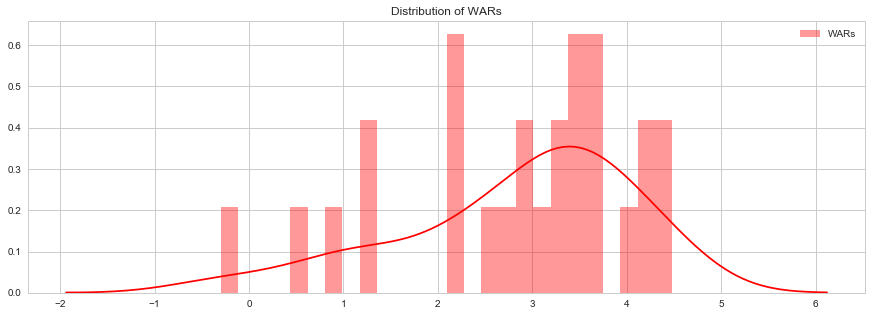

In [38]:
import seaborn as sns

# Use Seaborn to plot the histograms
sns.distplot(wars2, color='red', bins=26, label='WARs')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of WARs')
plt.show()

In [10]:
opss2 = data["OPS"].values
opss2

array([0.44825   , 0.4026    , 0.432     , 0.3927    , 0.4317    ,
       0.4116    , 0.45      , 0.35966667, 0.410625  , 0.36416667,
       0.376     , 0.4235    , 0.4347    , 0.38275   , 0.4005    ,
       0.41366667, 0.389     , 0.409     , 0.42992857, 0.40383333,
       0.44975   , 0.418125  , 0.372     , 0.440875  , 0.39733333,
       0.429375  ])

d:\Anaconda3.5.1\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


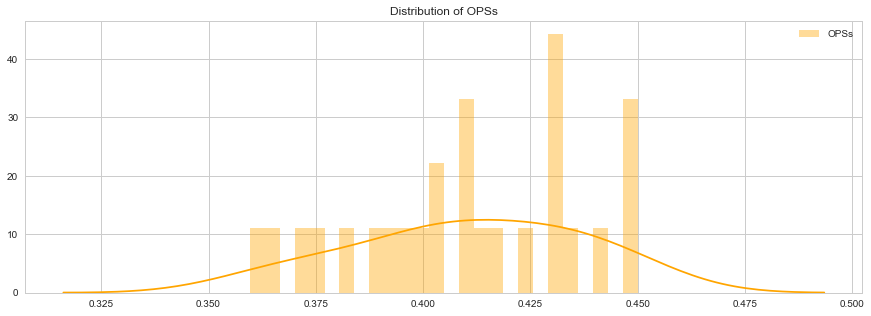

In [39]:
import seaborn as sns

# Use Seaborn to plot the histograms
sns.distplot(opss2, color='orange', bins=26, label='OPSs')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of OPSs')
plt.show()

In [11]:
babips = data["BABIPs"].values
babips

array([0.82      , 0.7665    , 0.76933333, 0.77925   , 0.717     ,
       0.741     , 0.79066667, 0.7435    , 0.774     , 0.692     ,
       0.738     , 0.74033333, 0.7685    , 0.73      , 0.7535    ,
       0.632     , 0.7735    , 0.753     , 0.717     , 0.78033333,
       0.681     , 0.7125    , 0.744     , 0.7055    , 0.73233333,
       0.704     ])

d:\Anaconda3.5.1\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


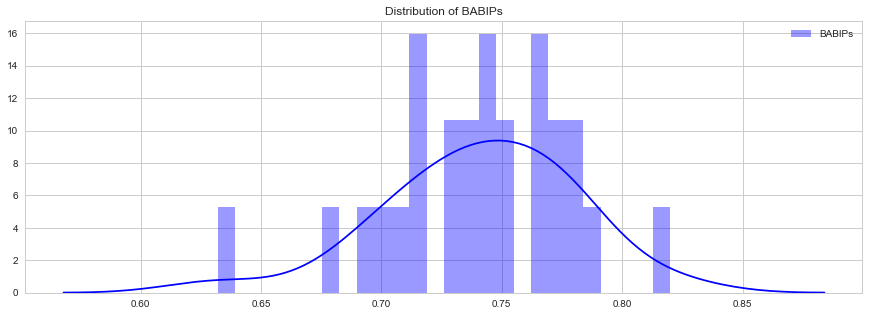

In [40]:
import seaborn as sns

# Use Seaborn to plot the histograms
sns.distplot(babips, color='blue', bins=26, label='BABIPs')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of BABIPs')
plt.show()

In [12]:
fips = data["FIPs"].values
fips

array([3.39333333, 4.99      , 4.14333333, 4.19      , 4.05      ,
       4.17      , 3.39666667, 4.665     , 3.23      , 5.11      ,
       5.17      , 3.66666667, 3.685     , 4.36      , 4.29      ,
       4.31      , 4.225     , 3.28      , 4.62      , 3.81      ,
       3.54      , 4.785     , 3.88      , 4.505     , 4.61333333,
       4.29      ])

d:\Anaconda3.5.1\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


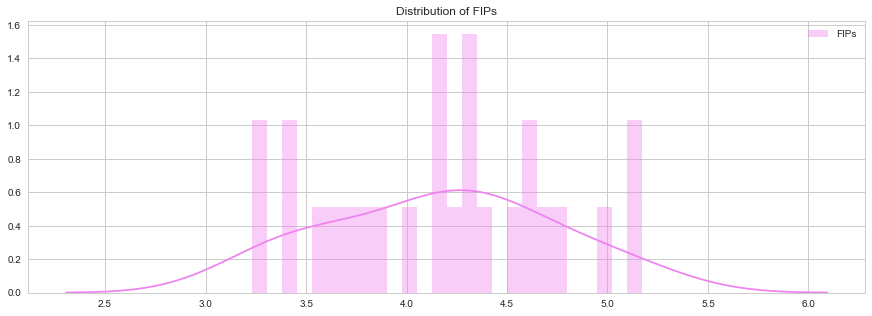

In [41]:
import seaborn as sns

# Use Seaborn to plot the histograms
sns.distplot(fips, color='violet', bins=26, label='FIPs')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of FIPs')
plt.show()

In [22]:
teams_wl2 = data["WL"]
teams_wl2

0     52
1     32
2     32
3     20
4      6
5      8
6     50
7     -8
8     24
9    -26
10   -48
11    10
12    24
13   -22
14     0
15   -24
16    -6
17    30
18     6
19   -12
20   -20
21   -44
22   -67
23    40
24   -17
25    44
Name: WL, dtype: int64

In [33]:
teams_wl2.values

array([ 52,  32,  32,  20,   6,   8,  50,  -8,  24, -26, -48,  10,  24,
       -22,   0, -24,  -6,  30,   6, -12, -20, -44, -67,  40, -17,  44],
      dtype=int64)

In [13]:
len(fips) == len(babips) == len(opss2) == len(wars2)

True

In [16]:
new_num_teams = len(fips)
new_num_teams

26

In [18]:
mlb_teams_by_rbis_index_2 = range(0, 26)
mlb_teams_by_rbis_index_2

range(0, 26)

d:\Anaconda3.5.1\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


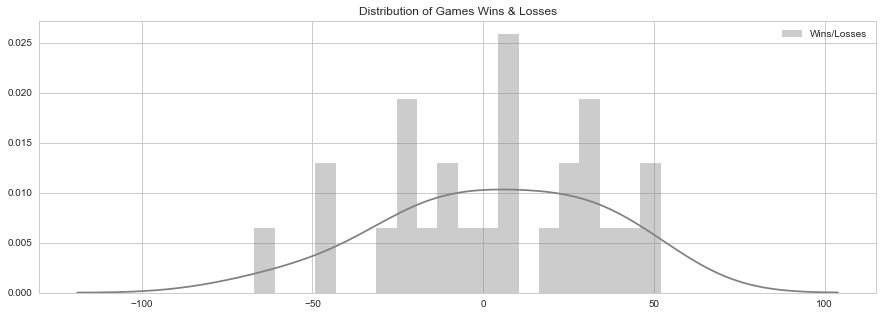

In [42]:
import seaborn as sns

# Use Seaborn to plot the histograms
sns.distplot(teams_wl2.values, color='gray', bins=20, label='Wins/Losses')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of Games Wins & Losses')
plt.show()

In [53]:
from sklearn import preprocessing
data["WL3"] = preprocessing.scale(data['WL']) 
teams_wl3 = data["WL3"].values
teams_wl3

d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 1.58541127,  0.93524261,  0.93524261,  0.54514141,  0.09002335,
        0.15504022,  1.5203944 , -0.36509471,  0.67517515, -0.9502465 ,
       -1.66543203,  0.22005708,  0.67517515, -0.82021277, -0.10502724,
       -0.88522964, -0.30007784,  0.87022574,  0.09002335, -0.49512844,
       -0.7551959 , -1.5353983 , -2.28309225,  1.19531007, -0.65767061,
        1.32534381])

In [54]:
data

,Team,WARs,OPS,BABIPs,FIPs,WL,WL3
0,Astros,4.483333,0.448250,0.820000,3.393333,52,1.585411
1,Athletics,3.580000,0.402600,0.766500,4.990000,32,0.935243
2,Braves,4.120000,0.432000,0.769333,4.143333,32,0.935243
3,Cardinals,2.960000,0.392700,0.779250,4.190000,20,0.545141
4,Cubs,3.540000,0.431700,0.717000,4.050000,6,0.090023
5,Diamondbacks,3.060000,0.411600,0.741000,4.170000,8,0.155040
6,Dodgers,4.460000,0.450000,0.790667,3.396667,50,1.520394
7,Giants,0.966667,0.359667,0.743500,4.665000,-8,-0.365095
8,Indians,3.300000,0.410625,0.774000,3.230000,24,0.675175
9,Mariners,0.533333,0.364167,0.692000,5.110000,-26,-0.950247


d:\Anaconda3.5.1\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


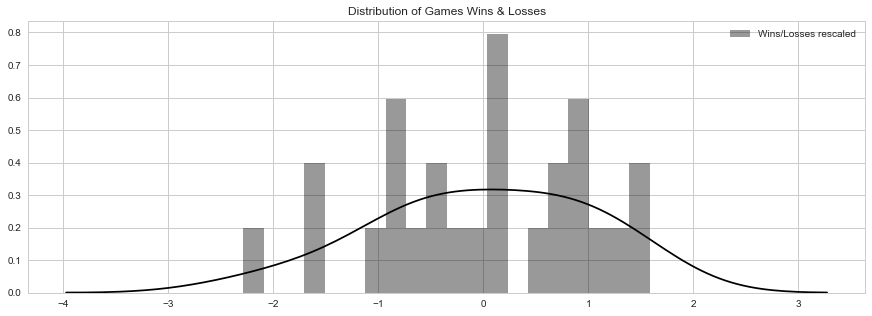

In [45]:
import seaborn as sns

# Use Seaborn to plot the histograms
sns.distplot(teams_wl3, color='black', bins=20, label='Wins/Losses rescaled')

sns.set(style="whitegrid")
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = [15, 5]

plt.title('Distribution of Games Wins & Losses')
plt.show()

Ok, can go back to run the model, now :-)

## @@@@@@@@@@@@ End read pickle

## @@@@@@@@@@@@@@@@@ Junkyard

A few attempts, trying different things out here.

Let's rescale `WL` column.

In [5]:
from sklearn import preprocessing
teams_wl3 = preprocessing.scale(teams_wl2) 
teams_wl3

NameError: name 'teams_wl2' is not defined

alternatively:

In [9]:
from sklearn import preprocessing
teams_wl3 = preprocessing.scale(data['WL']) 
teams_wl3

d:\Anaconda3.5.1\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 1.58541127,  0.93524261,  0.93524261,  0.54514141,  0.09002335,
        0.15504022,  1.5203944 , -0.36509471,  0.67517515, -0.9502465 ,
       -1.66543203,  0.22005708,  0.67517515, -0.82021277, -0.10502724,
       -0.88522964, -0.30007784,  0.87022574,  0.09002335, -0.49512844,
       -0.7551959 , -1.5353983 , -2.28309225,  1.19531007, -0.65767061,
        1.32534381])

In [10]:
data['WL3'] = teams_wl3
data

,Team,WARs,OPS,BABIPs,FIPs,WL,WL3
0,Astros,4.483333,0.448250,0.820000,3.393333,52,1.585411
1,Athletics,3.580000,0.402600,0.766500,4.990000,32,0.935243
2,Braves,4.120000,0.432000,0.769333,4.143333,32,0.935243
3,Cardinals,2.960000,0.392700,0.779250,4.190000,20,0.545141
4,Cubs,3.540000,0.431700,0.717000,4.050000,6,0.090023
5,Diamondbacks,3.060000,0.411600,0.741000,4.170000,8,0.155040
6,Dodgers,4.460000,0.450000,0.790667,3.396667,50,1.520394
7,Giants,0.966667,0.359667,0.743500,4.665000,-8,-0.365095
8,Indians,3.300000,0.410625,0.774000,3.230000,24,0.675175
9,Mariners,0.533333,0.364167,0.692000,5.110000,-26,-0.950247


Ok, we have our `data`, let's run a sim:

In [ ]:
import pymc3 as pm
with pm.Model() as glm_model:
    # Define priors for intercept and regression coefficients
    priors = {'Intercept': pm.Normal.dist(mu=0., sd=100.),
              'WARs': pm.Normal.dist(mu=0., sd=100.),
              'OPS': pm.Normal.dist(mu=0., sd=100.),
              'BABIPs': pm.Normal.dist(mu=0., sd=100.),
              'FIPs': pm.Normal.dist(mu=0., sd=100.)
              }
    pm.glm.GLM.from_formula('WL ~ WARs + OPS + BABIPs + FIPs',
                            data,
                            family=pm.glm.families.Poisson())
    trace = pm.sample(1000, tune=1000, init='adapt_diag', njobs=1)

hmm... doesn't seem to like **normal** priors with **Poisson** likelihood...

Let's try this instead, with all **normal** pdfs:

In [ ]:
import pymc3 as pm
with pm.Model() as glm_model:
    pm.glm.GLM.from_formula('WL3 ~ WARs + OPS + BABIPs + FIPs',
                            data,
                            family=pm.glm.families.Normal())
    trace = pm.sample(1000, tune=1000, init='adapt_diag', njobs=1)

In [88]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mn), xy=(mn, 0), xycoords='data',
                          xytext=(5, 10), textcoords='offset points', rotation=90,
                          va='bottom', fontsize='large', color='#AA0022')

d:\Anaconda3.5.1\lib\site-packages\pymc3\stats.py:974: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


TypeError: tuple indices must be integers or slices, not str

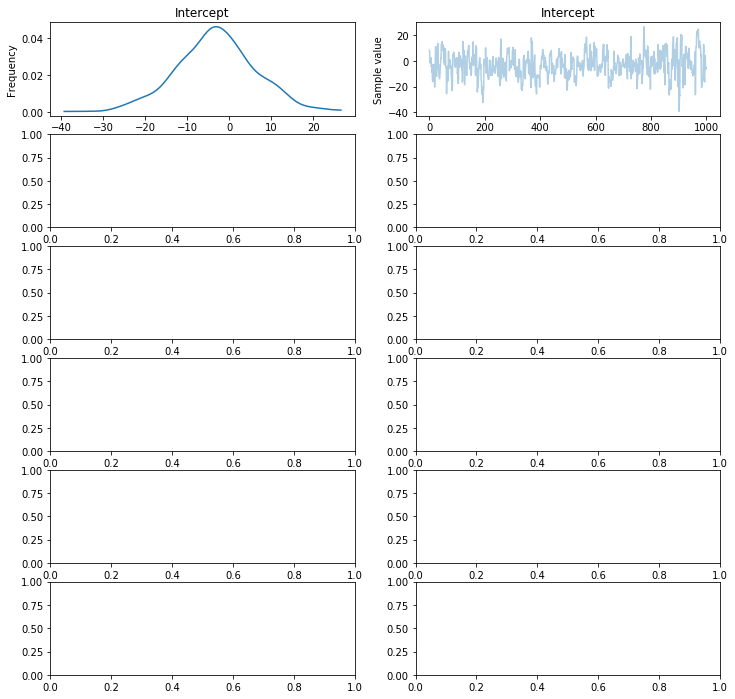

In [95]:
plot_traces(trace, retain=1000)

In [94]:
trace

<MultiTrace: 2 chains, 1000 iterations, 7 variables>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207FDAAD7F0>,
      dtype=object)

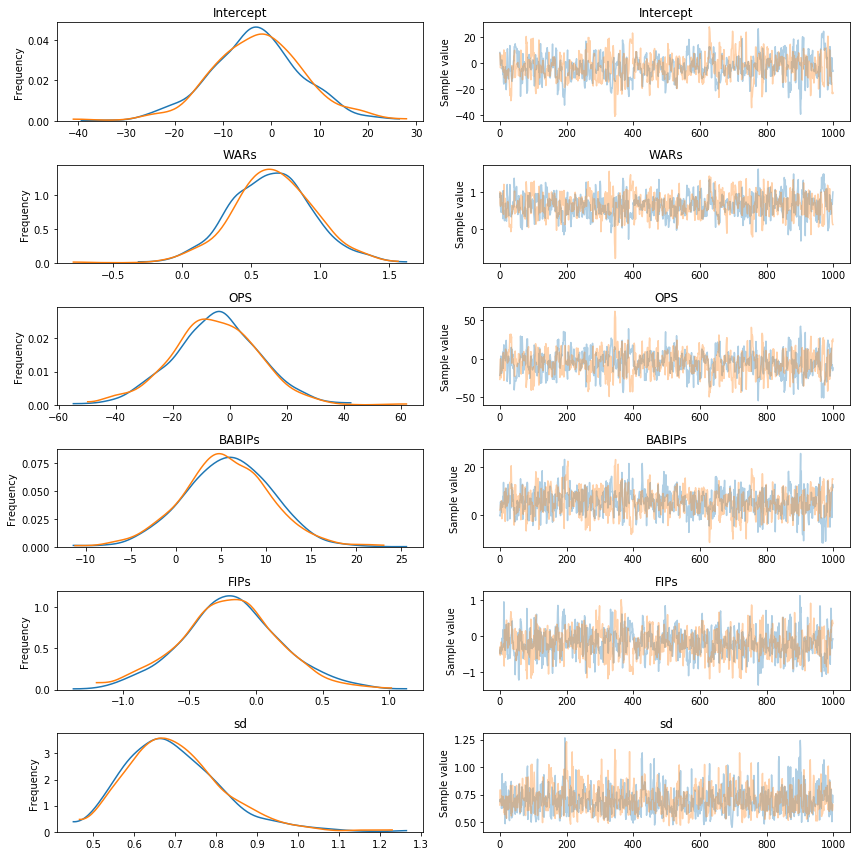

In [93]:
pm.traceplot(trace)

same sim, using **explicit** model:

In [ ]:
import pymc3 as pm
with pm.Model() as mdl_ols:
    ## define Normal priors to give Ridge regression
    bias = pm.Normal('bias', mu=0, sd=100)
    a0 = pm.Normal('a0', mu=0, sd=100)
    a1 = pm.Normal('a1', mu=0, sd=100)
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)

    ## define Linear model
    yest = bias + a0 * data['WARs'] + a1 * data['OPS'] + b0 * data['BABIPs'] + b1 * data['FIPs']

    ## define Normal likelihood with HalfCauchy noise (fat tails, equiv to HalfT 1DoF)
    sd_y = pm.HalfCauchy('sd_y', beta=10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=sd_y, observed=data['WL3'])

    traces_ols = pm.sample(2000, njobs=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000223DB6308D0>,
      dtype=object)

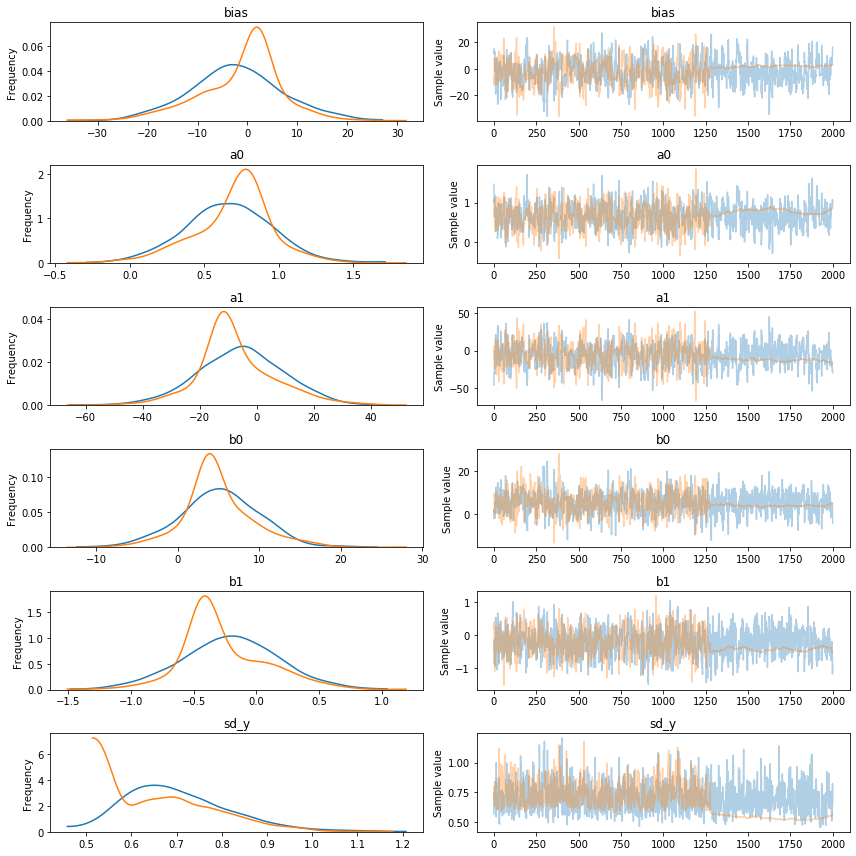

In [13]:
pm.traceplot(traces_ols)

strange.. Let's try with a Poisson likelihood, again:

In [15]:
data['WL'].values.T

array([ 52,  32,  32,  20,   6,   8,  50,  -8,  24, -26, -48,  10,  24,
       -22,   0, -24,  -6,  30,   6, -12, -20, -44, -67,  40, -17,  44],
      dtype=int64)

In [16]:
len(data['WL'].values)

26

In [18]:
import pymc3 as pm
with pm.Model() as mdl_poi:
    ## define Normal priors to give Ridge regression
    bias = pm.Normal('bias', mu=0, sd=100)
    a0 = pm.Normal('a0', mu=0, sd=100)
    a1 = pm.Normal('a1', mu=0, sd=100)
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)

    ## define Linear model
    theta = bias + a0 * data['WARs'] + a1 * data['OPS'] + b0 * data['BABIPs'] + b1 * data['FIPs']

    ## define Poisson likelihood (use numpy's exp() or theano's?)
    likelihood = pm.Poisson('likelihood', mu=np.exp(theta), observed=data['WL'].values)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0, a1, a0, bias]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

In [ ]:
with pm.Model() as mdl_poi:
    traces_poi = pm.sample(2000, njobs=1)

`Bad initial energy problem` is an indication that one of the computations returns an invalid number (likely the likelihood contains nan or inf). 

You can check which RV is causing problem by doing:
`model.check_test_point()`.

In [19]:
mdl_poi.check_test_point()

bias         -5.52
a0           -5.52
a1           -5.52
b0           -5.52
b1           -5.52
likelihood    -inf
Name: Log-probability of test_point, dtype: float64

In [27]:
import pymc3 as pm, theano.tensor as tt
with pm.Model() as mdl_poi:
    ## define Normal priors to give Ridge regression
    bias = pm.Normal('bias', mu=0, sd=100)
    a0 = pm.Normal('a0', mu=0, sd=100)
    a1 = pm.Normal('a1', mu=0, sd=100)
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Normal('b1', mu=0, sd=100)

    ## define Linear model
    theta = bias + a0 * data['WARs'] + a1 * data['OPS'] + b0 * data['BABIPs'] + b1 * data['FIPs']

    ## define Poisson likelihood (use numpy's exp() or theano's?)
    #likelihood = pm.Poisson('likelihood', mu=np.exp(theta), observed=data['WL'].values)
    likelihood = pm.Poisson('likelihood', mu=tt.exp(theta), observed=data['WL'].values)
    
    # NUTS:
    trace_poi = pm.sample(1000, tune=1000, init='adapt_diag', njobs=1)
    
    # Metropolis: yields 0
    #trace_poi = pm.sample(step=pm.Metropolis(), draws=10000, njobs=1, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b1, b0, a1, a0, bias]
  0%|          | 0/2000 [00:00<?, ?it/s]


ValueError: Bad initial energy: inf. The model might be misspecified.

In [28]:
mdl_poi.check_test_point()

bias         -5.52
a0           -5.52
a1           -5.52
b0           -5.52
b1           -5.52
likelihood    -inf
Name: Log-probability of test_point, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000223DCCB0278>,
      dtype=object)

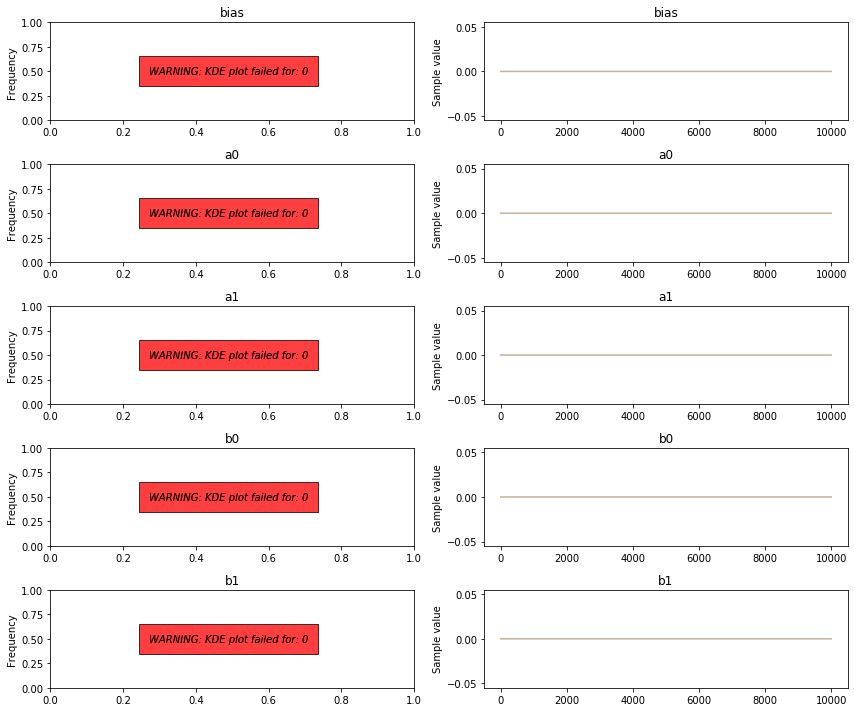

In [26]:
pm.traceplot(trace_poi)

In [ ]:
fake_data = pm.sample_ppc(trace, samples=1000, model=basic_model, size=100)
fake_data